In [1]:
# https://pypi.org/project/PuLP/
# https://coin-or.github.io/pulp/guides/index.html

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sqlite3 import connect
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 50)

In [6]:
pd.options.display.float_format = "{:.2f}".format

In [7]:
# Get the absolute path of the file within the INPUTS directory
file_path = os.path.join(os.getcwd(), 'INPUTS', 'case_study_data.csv')

# Print the file path
print(file_path)

C:\Users\KonuTech\PycharmProjects\supply-chain-case-study\INPUTS\case_study_data.csv


In [8]:
# Get the absolute path of the config within the CONFIGS directory
config_path = os.path.join(os.getcwd(), 'CONFIGS', 'config.json')

# Print the fileconfig_pathpath
print(config_path)

C:\Users\KonuTech\PycharmProjects\supply-chain-case-study\CONFIGS\config.json


In [95]:
with open(config_path, encoding='utf-8') as f:
    CONFIG = json.load(f)

In [96]:
INDEX_COL = CONFIG["INPUTS"]["INDEX_COLUMNS"]
SEP = CONFIG["INPUTS"]["SEPARATOR"]
DECIMAL = CONFIG["INPUTS"]["DECIMAL"]
ENCODING = CONFIG["INPUTS"]["ENCODING"]
DATE_COLUMNS = CONFIG["INPUTS"]["DATE_COLUMNS"]
FLOAT_PRECISION = CONFIG["INPUTS"]["FLOAT_PRECISION"]
DTYPE = CONFIG["INPUTS"]["DTYPE"]
COLUMNS_WITH_NAN_VALUES = CONFIG["INPUTS"]["COLUMNS_WITH_NAN_VALUES"]
X_ORDER = CONFIG["X_ORDER"]
HUE_ORDER = CONFIG["HUE_ORDER"]
COL_ORDER = CONFIG["COL_ORDER"]

In [11]:
df = pd.read_csv(
    file_path,
#     index_col=INDEX_COL,
    sep=SEP,
    encoding=ENCODING,
    engine="c",
    low_memory=False,
#     parse_dates=DATE_COLUMNS,
    dtype=DTYPE
)

In [12]:
print(df.index.duplicated())

[False False False ... False False False]


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9993 entries, 0 to 9992
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order ID      9993 non-null   object 
 1   Order Date    9993 non-null   object 
 2   Ship Mode     9993 non-null   object 
 3   Region        9993 non-null   object 
 4   Product ID    9993 non-null   object 
 5   Category      9993 non-null   object 
 6   Sub-Category  9993 non-null   object 
 7   Product Name  9993 non-null   object 
 8   Sales         9993 non-null   float64
 9   Quantity      9993 non-null   int64  
 10  Discount      9993 non-null   float64
 11  Profit        8000 non-null   float64
dtypes: float64(3), int64(1), object(8)
memory usage: 937.0+ KB


# PREPROCESSING

In [14]:
# df.index = pd.to_datetime(df["Order Date"])

In [15]:
# Use regex to separate the string parts of the Order ID column into separate fields
df[['Order ID prefix', 'Order ID year', 'Order ID number']] = df['Order ID'].str.extract(r'(\w+)-(\d+)-(\d+)')

# Use regex to separate the string parts of the Order Date column into separate fields
df[['Order Year', 'Order Month', 'Order Day']] = pd.to_datetime(df['Order Date']).dt.strftime('%Y-%m-%d').str.extract(r'(\d{4})-(\d{2})-(\d{2})')

In [16]:
# Normalize Profit column as new column
df['Normalized Profit'] = (df['Profit'] - df['Profit'].mean()) / df['Profit'].std()

In [17]:
# Normalize Sales column as new column
df['Normalized Sales'] = (df['Sales'] - df['Sales'].mean()) / df['Sales'].std()

In [18]:
# Standardize Profit column as new column
mean_profit = df['Profit'].mean()
std_profit = df['Profit'].std()
df['Standardized Profit'] = (df['Profit'] - mean_profit) / std_profit

In [19]:
# Standardize Sales column as new column
mean_sales = df['Sales'].mean()
std_sales = df['Sales'].std()
df['Standardized Sales'] = (df['Sales'] - mean_sales) / std_sales

In [20]:
df['Winsorized Sales'] = stats.mstats.winsorize(df['Sales'], limits=[0.05, 0.05])

In [21]:
df['Winsorized Profit'] = stats.mstats.winsorize(df['Profit'], limits=[0.10, 0.10])

In [22]:
# Use RobustScaler to scale Sales using IQR method as new column
scaler = RobustScaler()
df['Scaled Sales'] = scaler.fit_transform(df[['Sales']])
df['Scaled Profit'] = scaler.fit_transform(df[['Profit']])

In [23]:
# Create a FunctionTransformer object with a logarithmic transformation function
# log_transformer = FunctionTransformer(np.log1p)
log_transformer = FunctionTransformer(np.log10)

# Apply the logarithmic transformation to the "Sales" column
df['Log Sales'] = log_transformer.transform(df[['Sales']])
df['Log Profit'] = log_transformer.transform(df[['Profit']])

In [24]:
df["Category-SubCategory"] = df["Category"].str.cat(df["Sub-Category"], sep="-")

In [25]:
df_sample = df.sample(n=3000)
df_sample

Order ID  Order Date       Ship Mode   Region       Product ID  \
1328  PL-2015-164497  2015-11-28     First Class     West  OFF-AP-10004655   
7321  PL-2015-120320  2015-03-05  Standard Class  Central  TEC-PH-10000149   
9738  PL-2016-133613  2016-06-17  Standard Class     East  OFF-AR-10003829   
7063  PL-2014-124478  2014-08-08  Standard Class  Central  OFF-EN-10002500   
4890  SL-2016-164630  2016-01-04  Standard Class    South  TEC-CO-10000971   
7405  PL-2017-166856  2017-09-18  Standard Class     West  TEC-AC-10004992   
9442  PL-2017-105669  2017-09-17    Second Class  Central  OFF-AR-10000390   
8883  PL-2017-164756  2017-09-18  Standard Class    South  OFF-PA-10000673   
6458  PL-2015-163895  2015-08-07  Standard Class     West  OFF-BI-10004970   
641   PL-2015-108259  2015-11-08  Standard Class    South  OFF-FA-10000624   
8443  PL-2015-156510  2015-09-25  Standard Class     East  OFF-PA-10002222   
1570  PL-2015-113131  2015-09-24        Same Day     East  OFF-EN-10003068   
821   PL-2017-100622  2017-11-03  Standard Class    South  OFF-AR-10004010   
6965  SL-2016-153815  2016-11-06     First Class    South  FUR-FU-10004090   
9764  PL-2016-108196  2016-11-25  Standard Class     East  OFF-BI-10000545   
1266  PL-2015-151869  2015-09-25        Same Day     East  FUR-CH-10001545   
5490  PL-2016-107328  2016-08-08  Standard Class     West  OFF-AP-10004487   
8930  PL-2014-126963  2014-06-15        Same Day  Central  OFF-PA-10001952   
4090  SL-2016-146570  2016-05-15  Standard Class    South  OFF-AR-10003856   
7197  PL-2015-102015  2015-09-12  Standard Class     East  OFF-AR-10004685   
8749  PL-2017-124205  2017-09-15  Standard Class     East  FUR-CH-10003606   
45    PL-2016-113600  2016-12-15    Second Class     East  OFF-BI-10000201   
2115  PL-2016-103730  2016-06-12     First Class     East  OFF-EN-10002500   
1859  PL-2017-113278  2017-01-14  Standard Class  Central  TEC-PH-10000169   
8491  PL-2015-103135  2015-07-24  Standard Class    South  OFF-BI-10000069   
...              ...         ...             ...      ...              ...   
6330  PL-2015-125234  2015-11-27  Standard Class     West  TEC-AC-10000158   
6245  PL-2015-155068  2015-10-23        Same Day    South  OFF-AR-10002656   
9495  SL-2017-120147  2017-03-30        Same Day     West  OFF-AR-10000817   
7551  SL-2015-114741  2015-12-06  Standard Class     West  OFF-PA-10000048   
5642  PL-2015-168459  2015-11-22  Standard Class    South  OFF-FA-10004854   
8973  PL-2014-146990  2014-11-07     First Class     East  OFF-FA-10000611   
7409  SL-2017-125647  2017-09-23  Standard Class  Central  TEC-PH-10004188   
3386  PL-2017-124828  2017-07-03     First Class    South  OFF-AR-10003514   
2336  PL-2014-122336  2014-04-13    Second Class     East  TEC-PH-10000702   
4720  PL-2017-119193  2017-12-22     First Class     East  OFF-BI-10000848   
9750  PL-2017-112844  2017-11-13    Second Class     East  TEC-PH-10003988   
650   PL-2014-142769  2014-09-13        Same Day     West  FUR-FU-10001918   
3752  PL-2014-141817  2014-01-05  Standard Class     East  OFF-AR-10003478   
2513  PL-2015-157812  2015-03-22  Standard Class  Central  OFF-ST-10000736   
768   PL-2016-151148  2016-09-12        Same Day     West  TEC-PH-10001870   
26    PL-2015-132465  2015-09-11    Second Class     East  TEC-AC-10001998   
1614  PL-2014-128524  2014-11-11     First Class     West  OFF-BI-10003527   
1707  PL-2016-161746  2016-10-21  Standard Class     West  FUR-FU-10003731   
5663  PL-2014-129364  2014-12-08  Standard Class     West  OFF-PA-10001569   
9746  PL-2015-158323  2015-11-30     First Class    South  FUR-FU-10001546   
5922  PL-2016-162082  2016-03-14     First Class  Central  OFF-PA-10001934   
4257  PL-2016-131065  2016-11-14    Second Class    South  OFF-PA-10002479   
784   PL-2017-145765  2017-05-28  Standard Class     West  TEC-PH-10001305   
9265  SL-2016-150357  2016-10-10  Standard Class    South  OFF-SU-10004498   
5599  PL-2016-119683  2016-03-12  

# HISTOGRAMS

## Sales

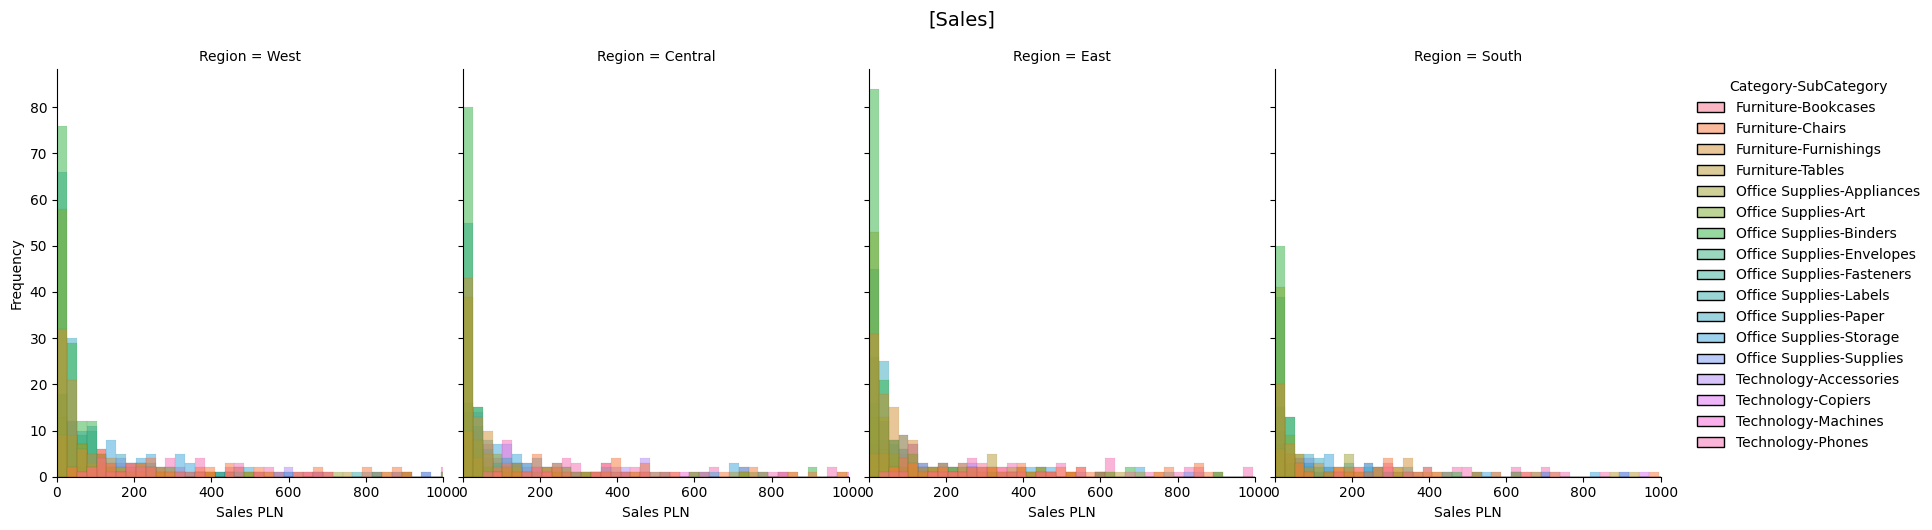

In [171]:
# Create a histogram with groupings based on Order Year
g = sns.displot(data=df_sample,
                x="Sales", hue="Category-SubCategory", kde=False, hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85)

# Customize the plot
g.set(xlim=(0, 1000), xlabel="Sales PLN", ylabel="Frequency")
g.fig.suptitle(f"[Sales]", fontsize=14, y=1.05)
# Show the plot
plt.show()

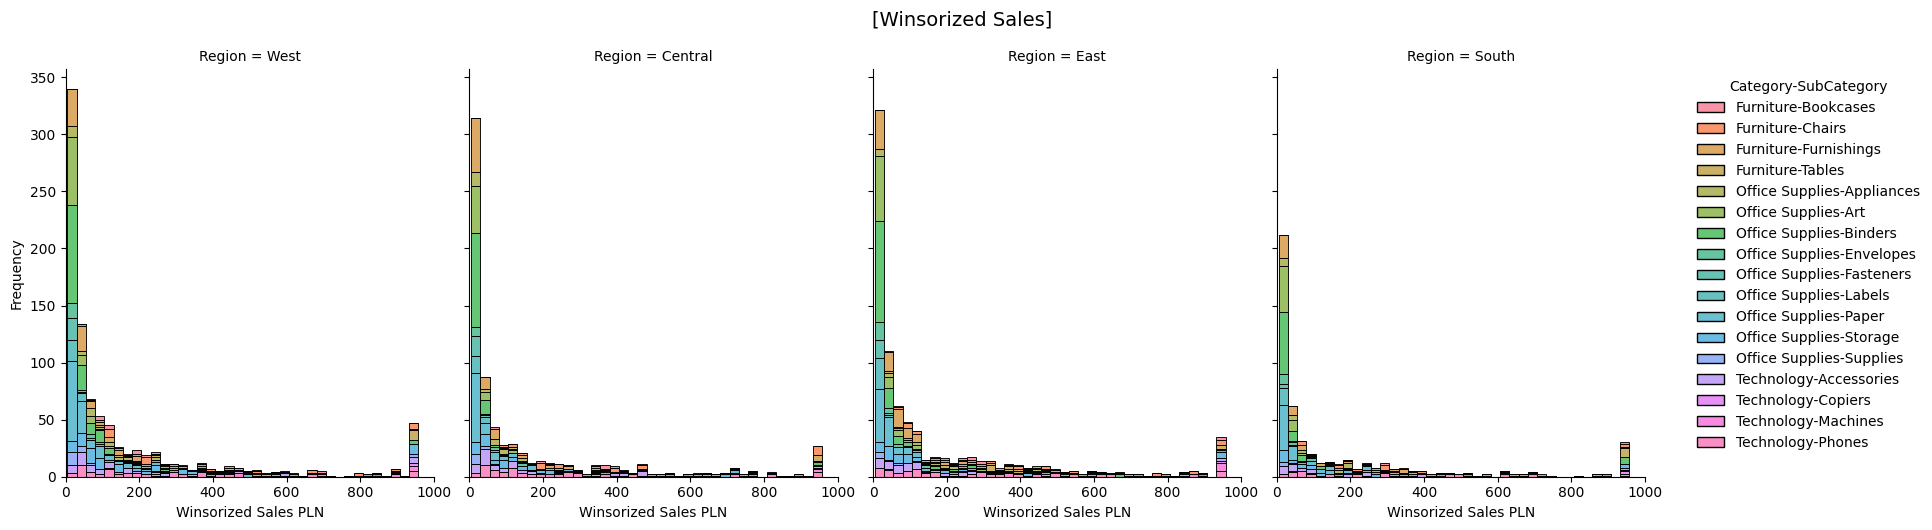

In [167]:
# Create a histogram with groupings based on Order Year
g = sns.displot(data=df_sample,
                x="Winsorized Sales", hue="Category-SubCategory", multiple="stack", kde=False, hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85)

# Customize the plot
g.set(xlim=(0, 1000), xlabel="Winsorized Sales PLN", ylabel="Frequency")
g.fig.suptitle(f"[Winsorized Sales]", fontsize=14, y=1.05)
# Show the plot
plt.show()

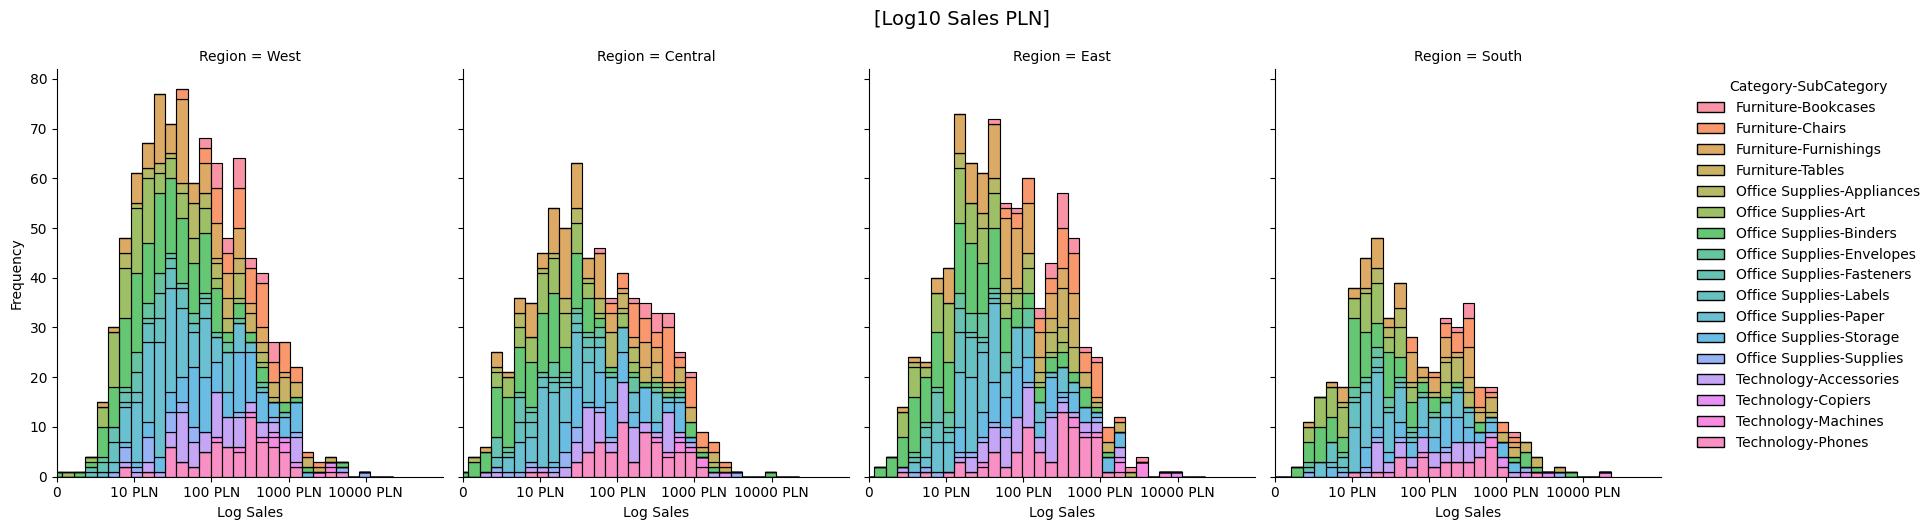

In [168]:
# Create a histogram with groupings based on Order Year
g = sns.displot(data=df_sample,
                x="Log Sales", hue="Category-SubCategory", multiple="stack", kde=False, hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85)

# Customize the plot
g.set(xlim=(0, 5), xlabel="Log Sales", ylabel="Frequency")
g.fig.suptitle(f"[Log10 Sales PLN]", fontsize=14, y=1.05)

# Set the x-axis ticks to [0, 10, 100, 1000]
g.set(xticks=[0, 1, 2, 3, 4], xticklabels=["0", "10 PLN", "100 PLN", "1000 PLN", "10000 PLN"])
# g.axes[0][0].xaxis.set_major_formatter(ticker.ScalarFormatter())

# Show the plot
plt.show()

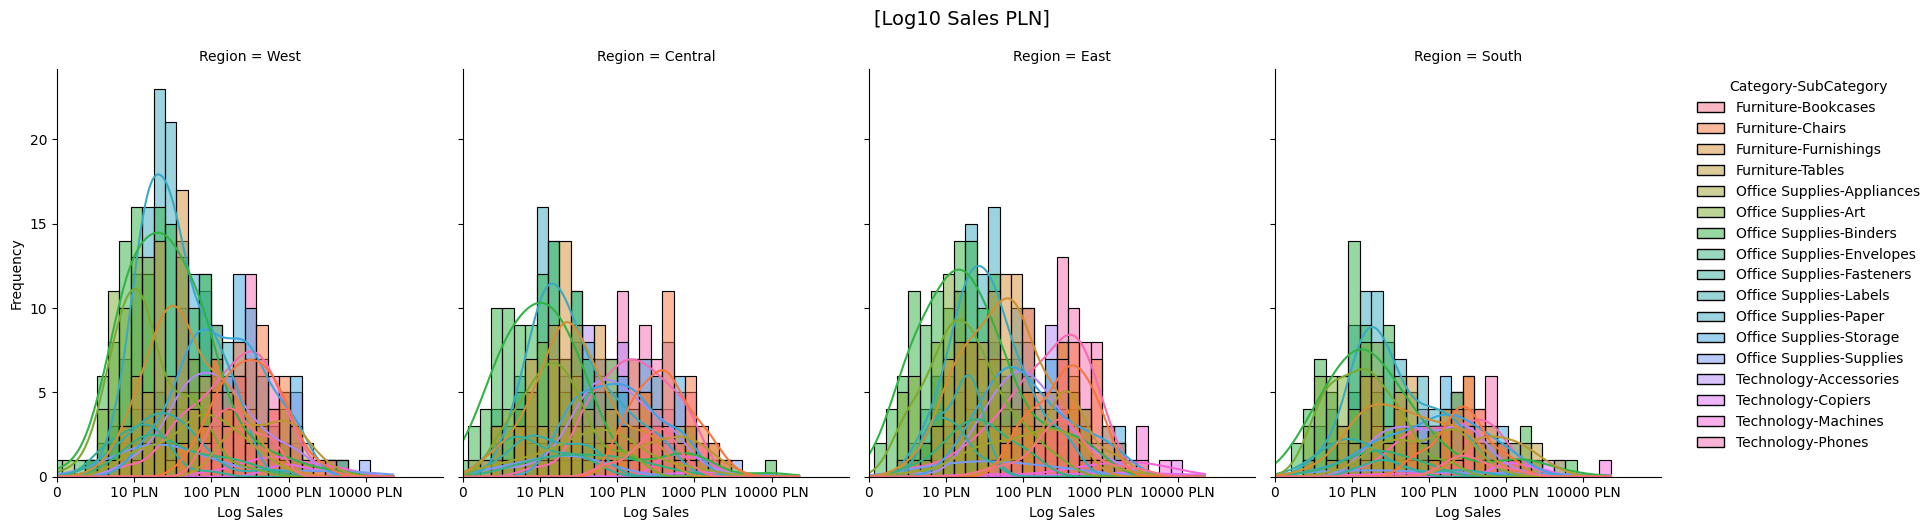

In [170]:
# Create a histogram with groupings based on Order Year
g = sns.displot(data=df_sample,
                x="Log Sales", hue="Category-SubCategory", kde=True, hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85)

# Customize the plot
g.set(xlim=(0, 5), xlabel="Log Sales", ylabel="Frequency")
g.fig.suptitle(f"[Log10 Sales PLN]", fontsize=14, y=1.05)

# Set the x-axis ticks to [0, 10, 100, 1000]
g.set(xticks=[0, 1, 2, 3, 4], xticklabels=["0", "10 PLN", "100 PLN", "1000 PLN", "10000 PLN"])
# g.axes[0][0].xaxis.set_major_formatter(ticker.ScalarFormatter())

# Show the plot
plt.show()

0 Office Supplies-Appliances


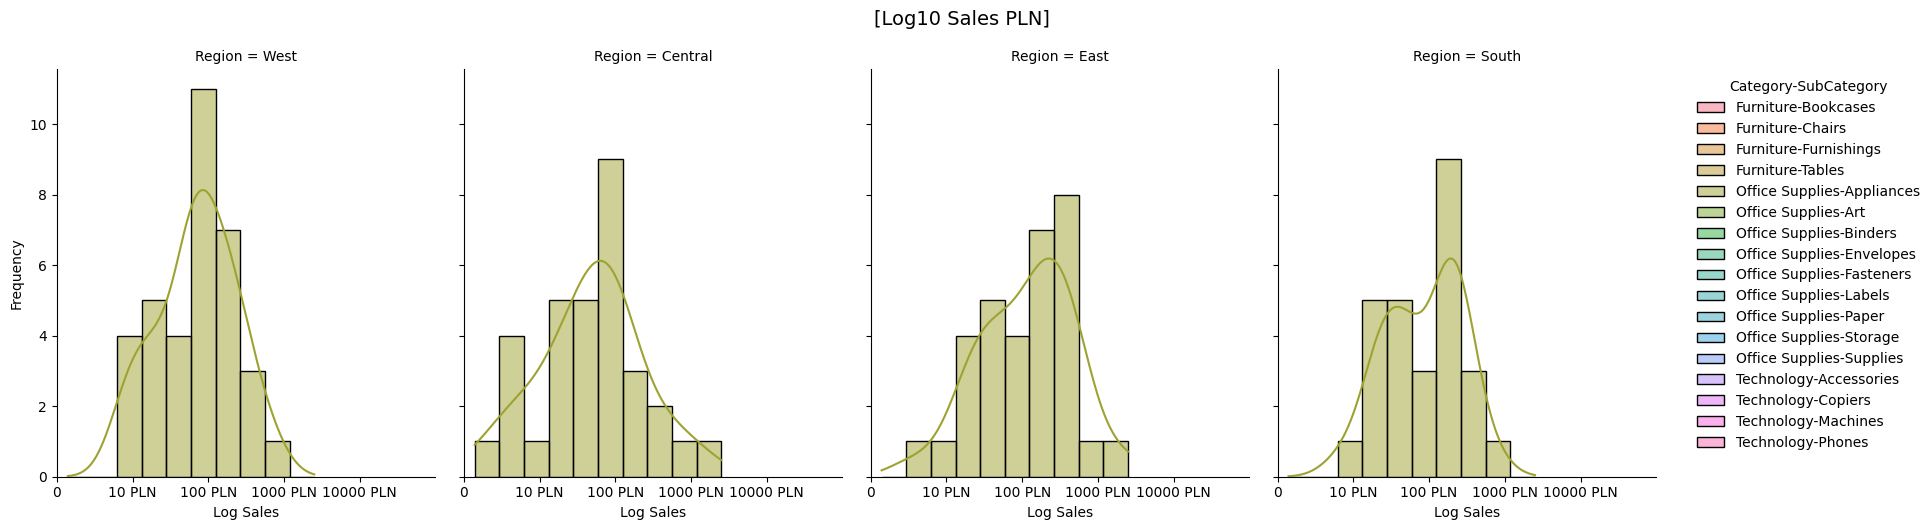

1 Technology-Phones


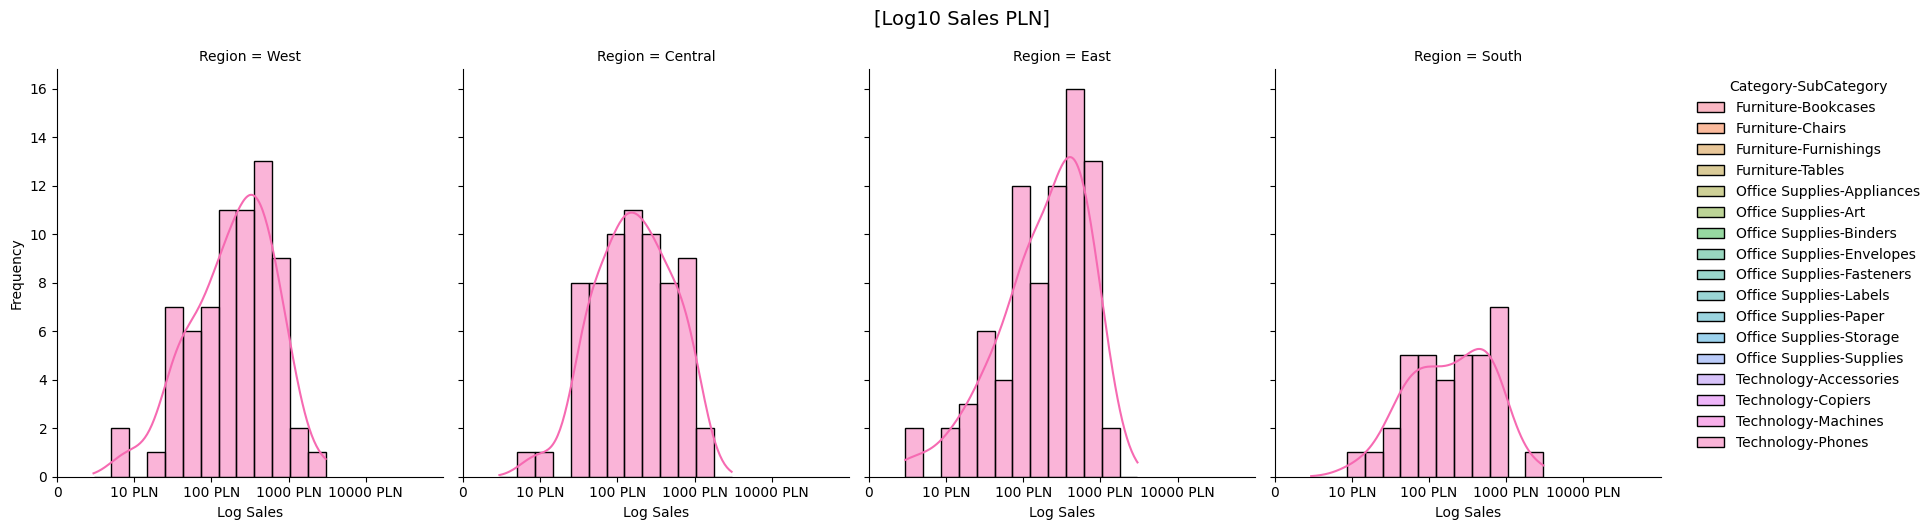

2 Office Supplies-Art


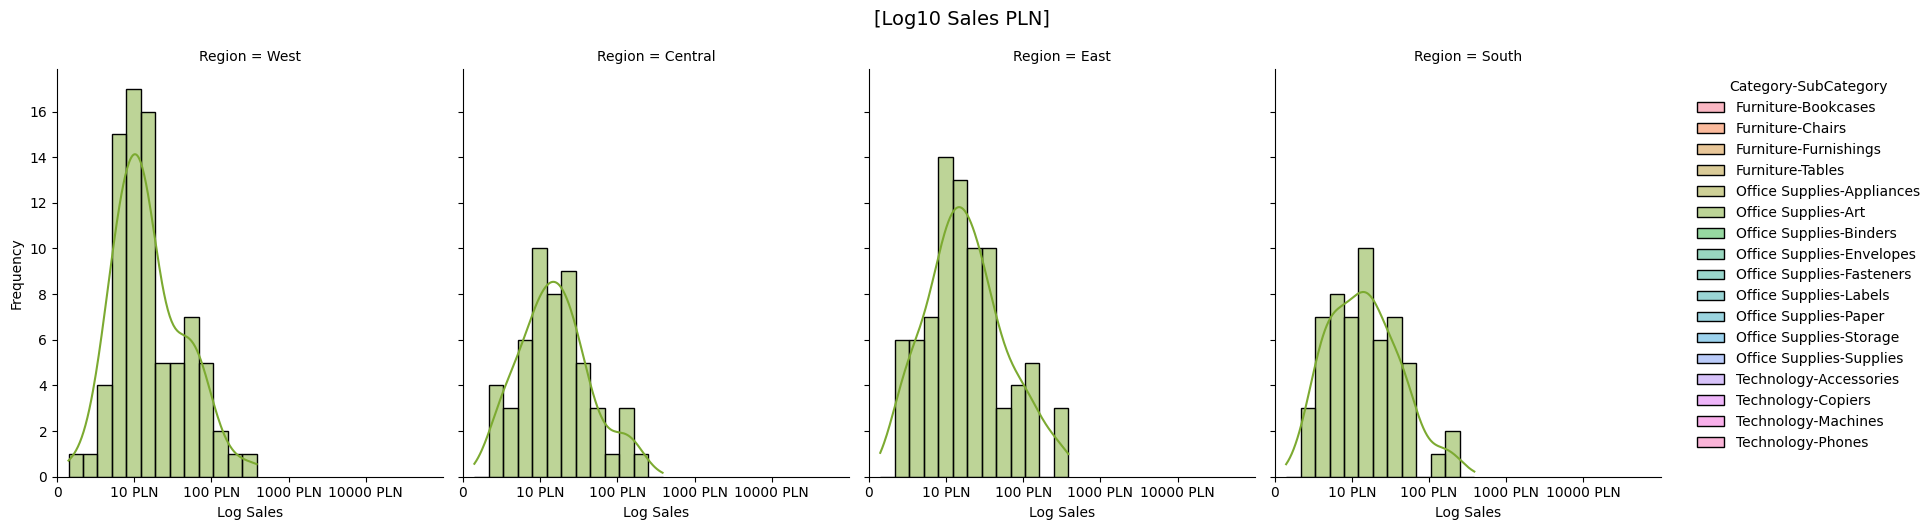

3 Office Supplies-Envelopes


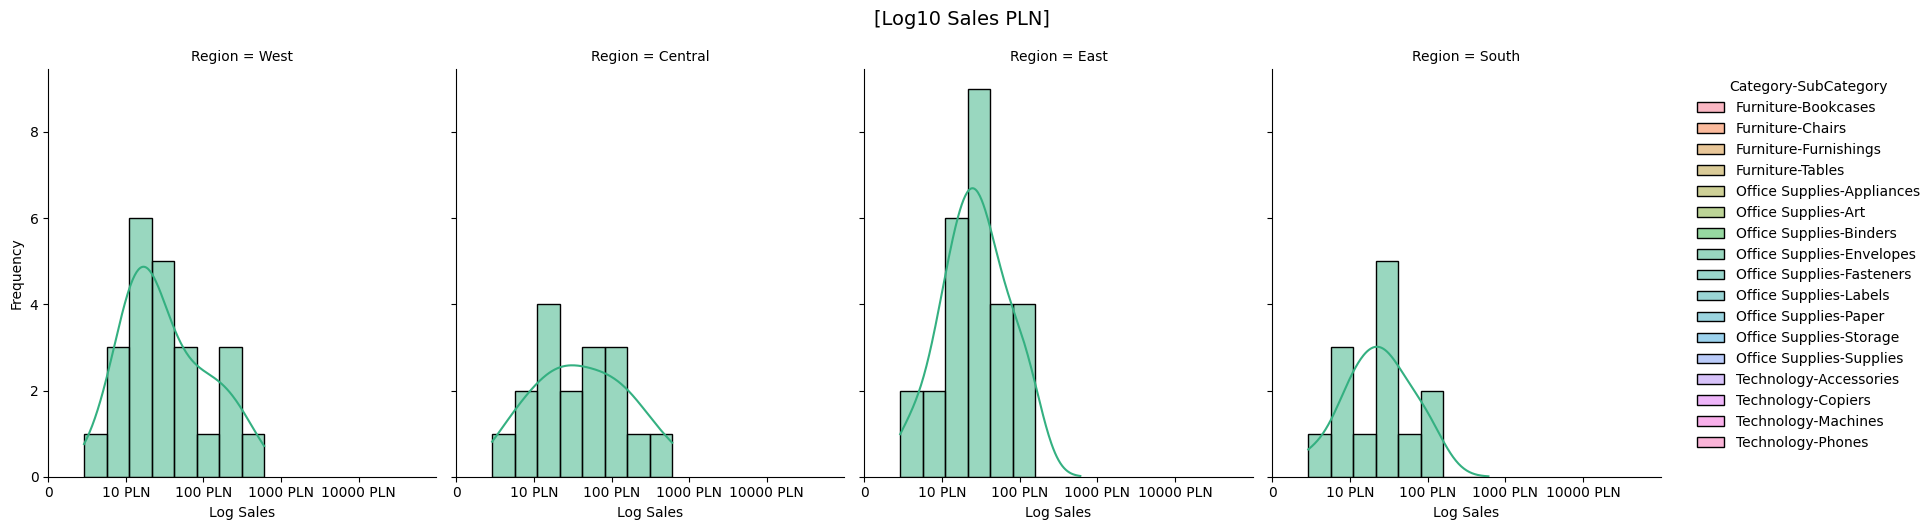

4 Technology-Copiers


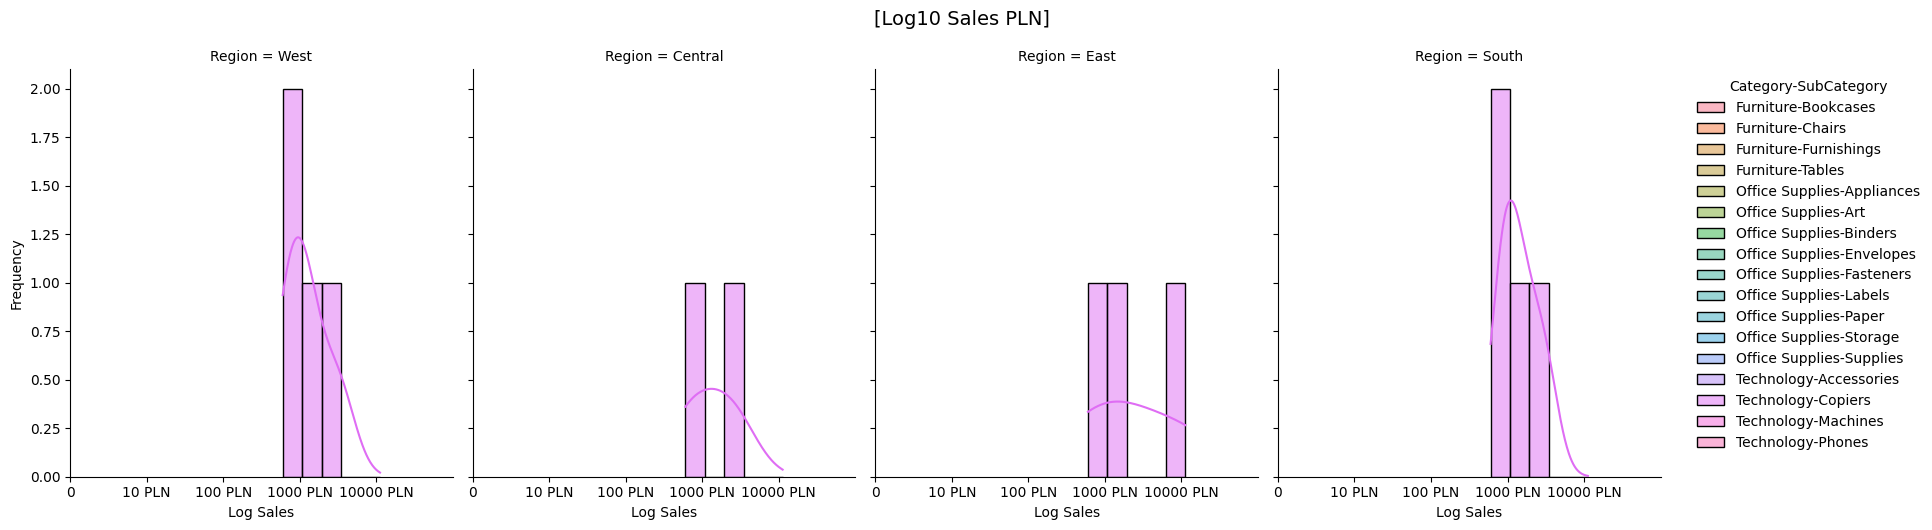

5 Technology-Accessories


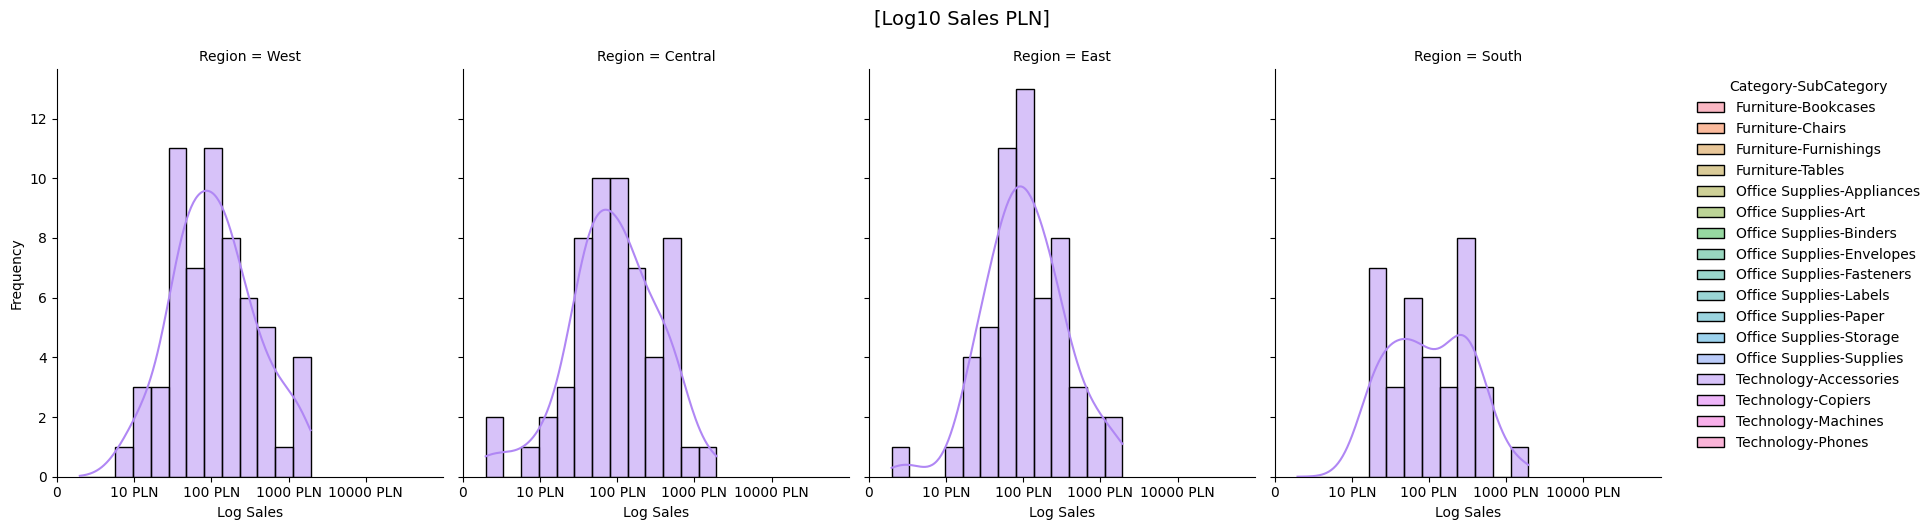

6 Office Supplies-Paper


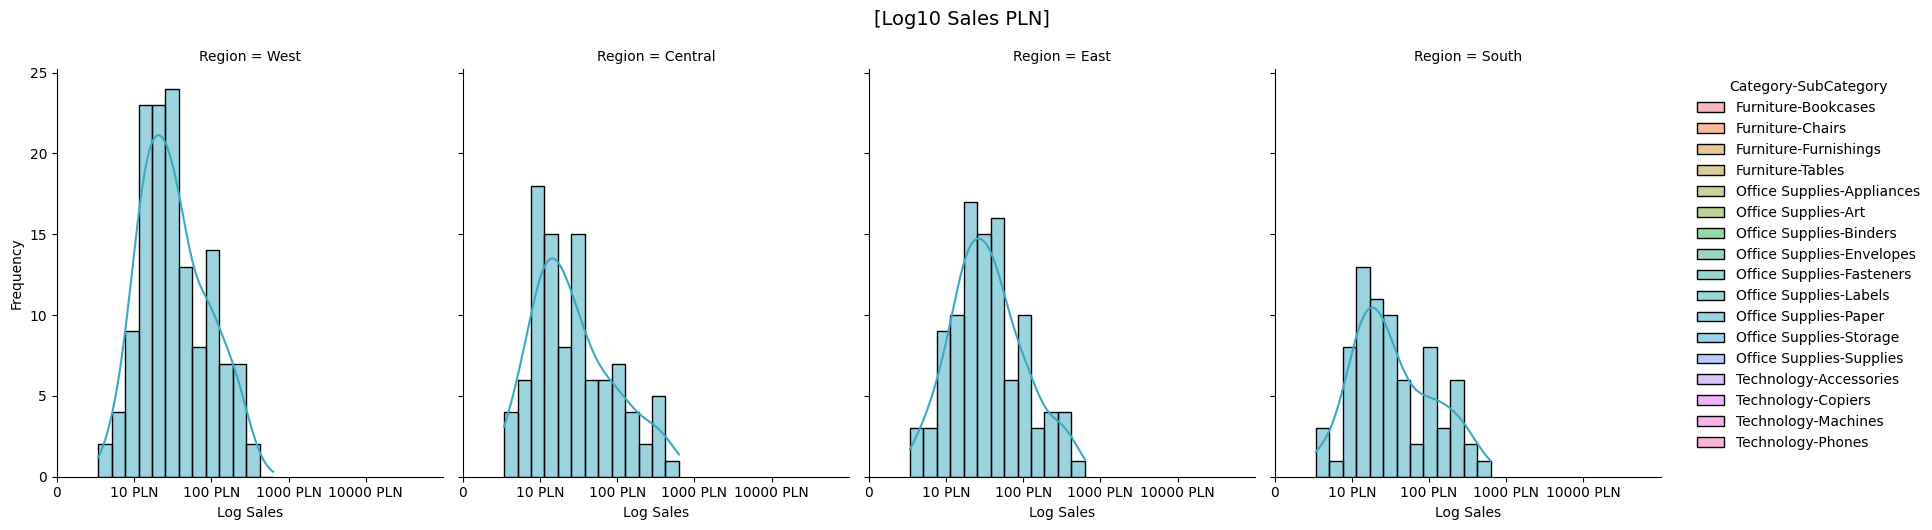

7 Office Supplies-Binders


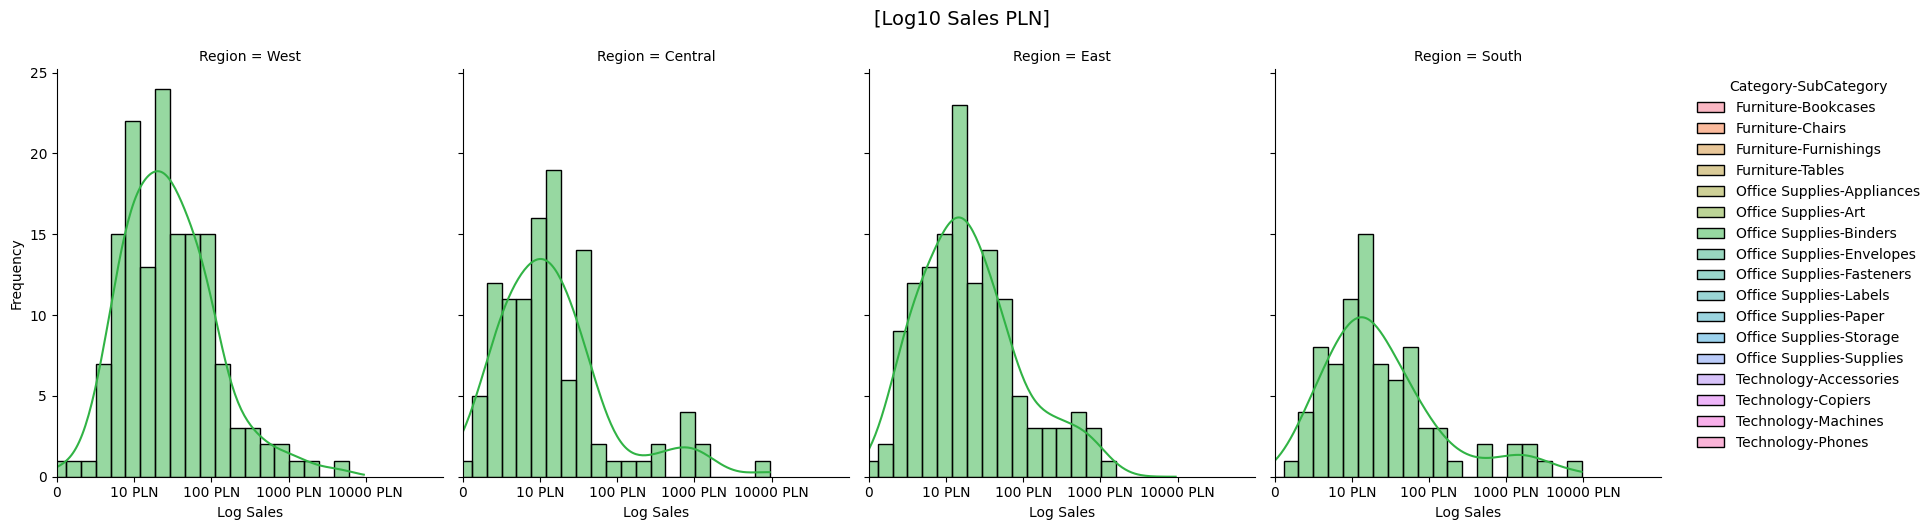

8 Office Supplies-Fasteners


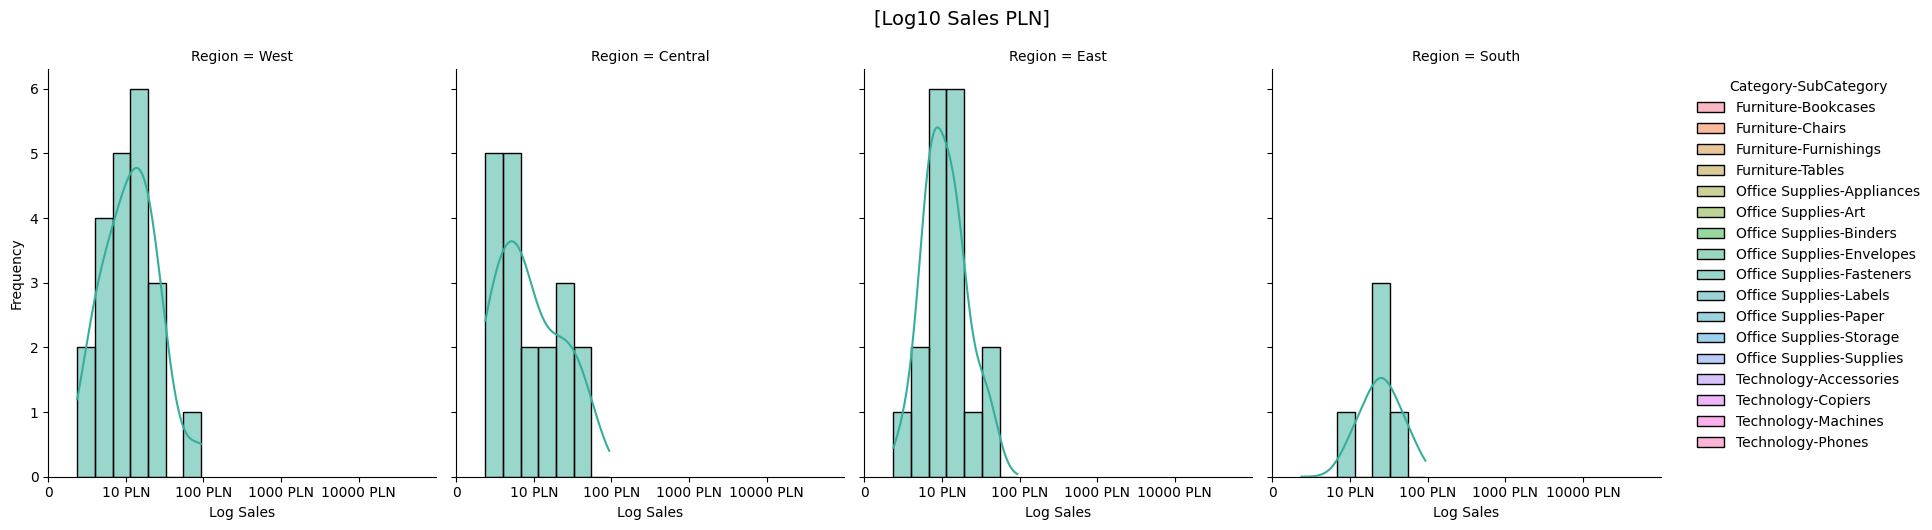

9 Furniture-Furnishings


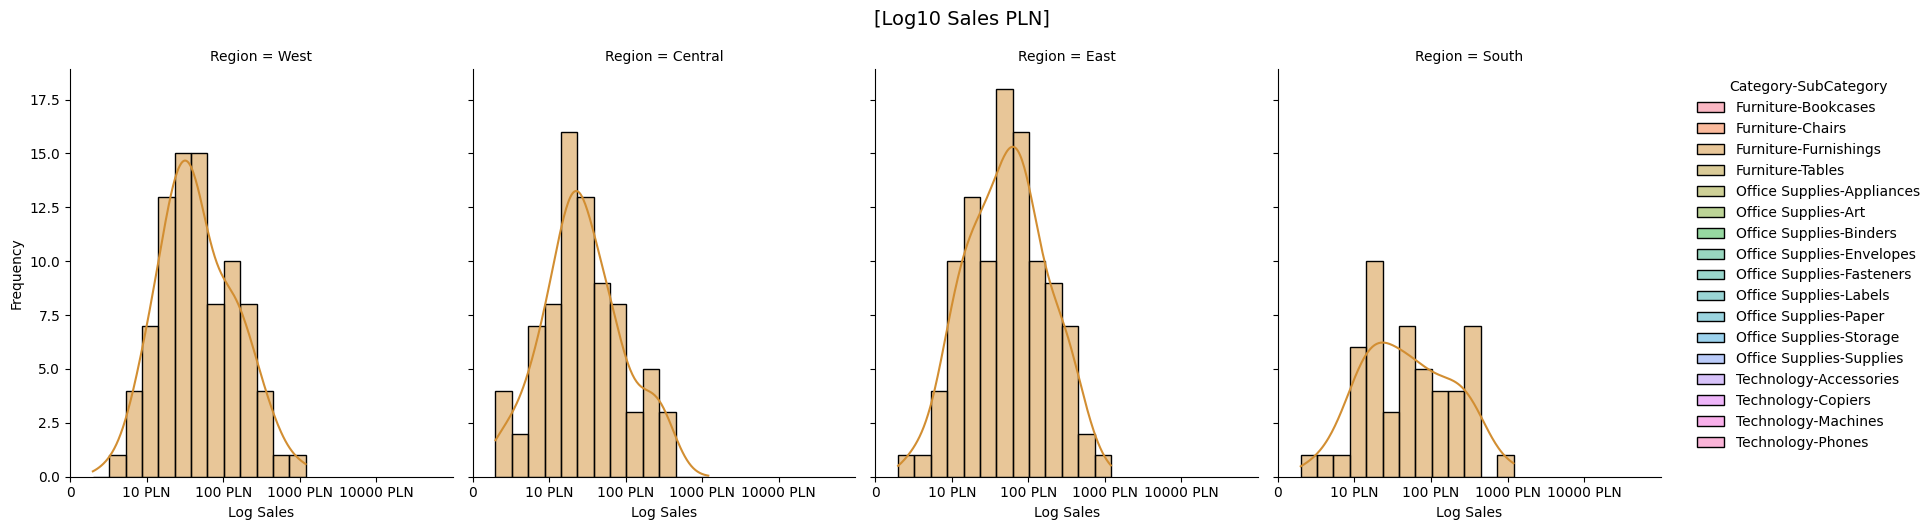

10 Furniture-Chairs


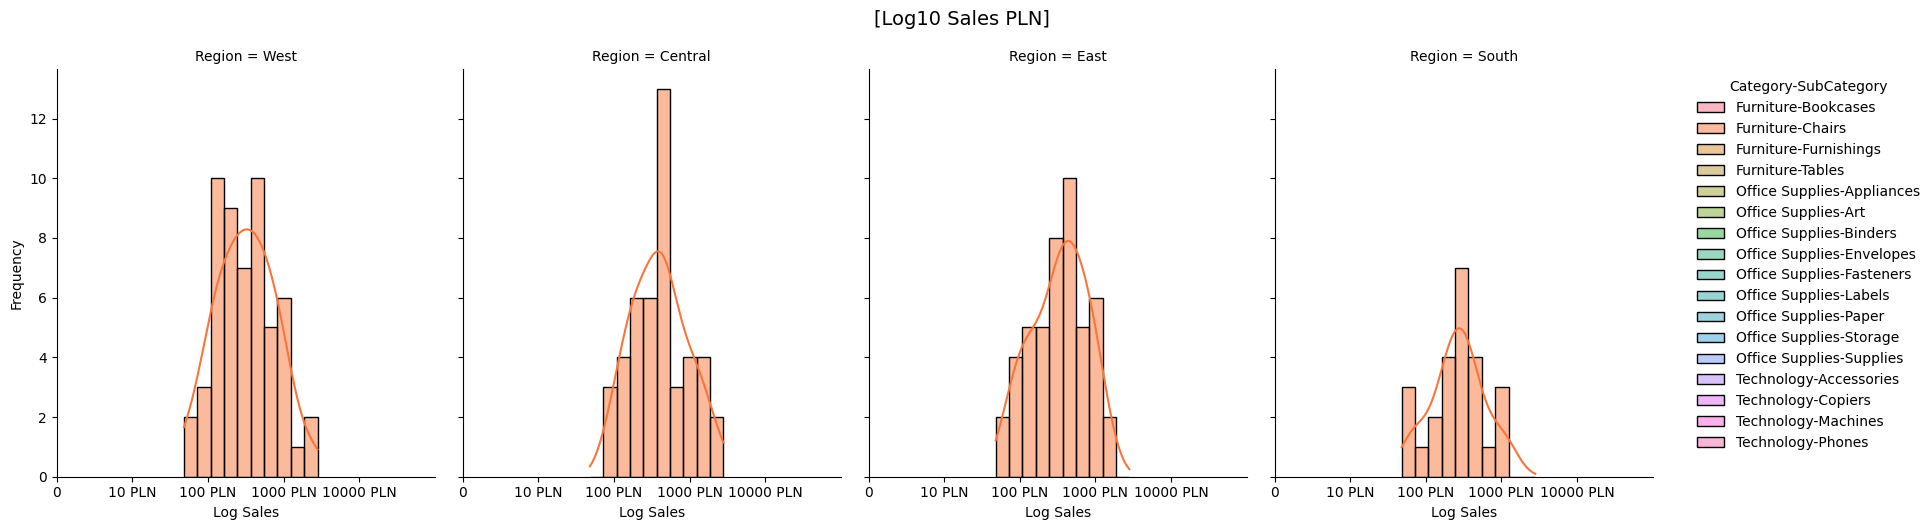

11 Furniture-Tables


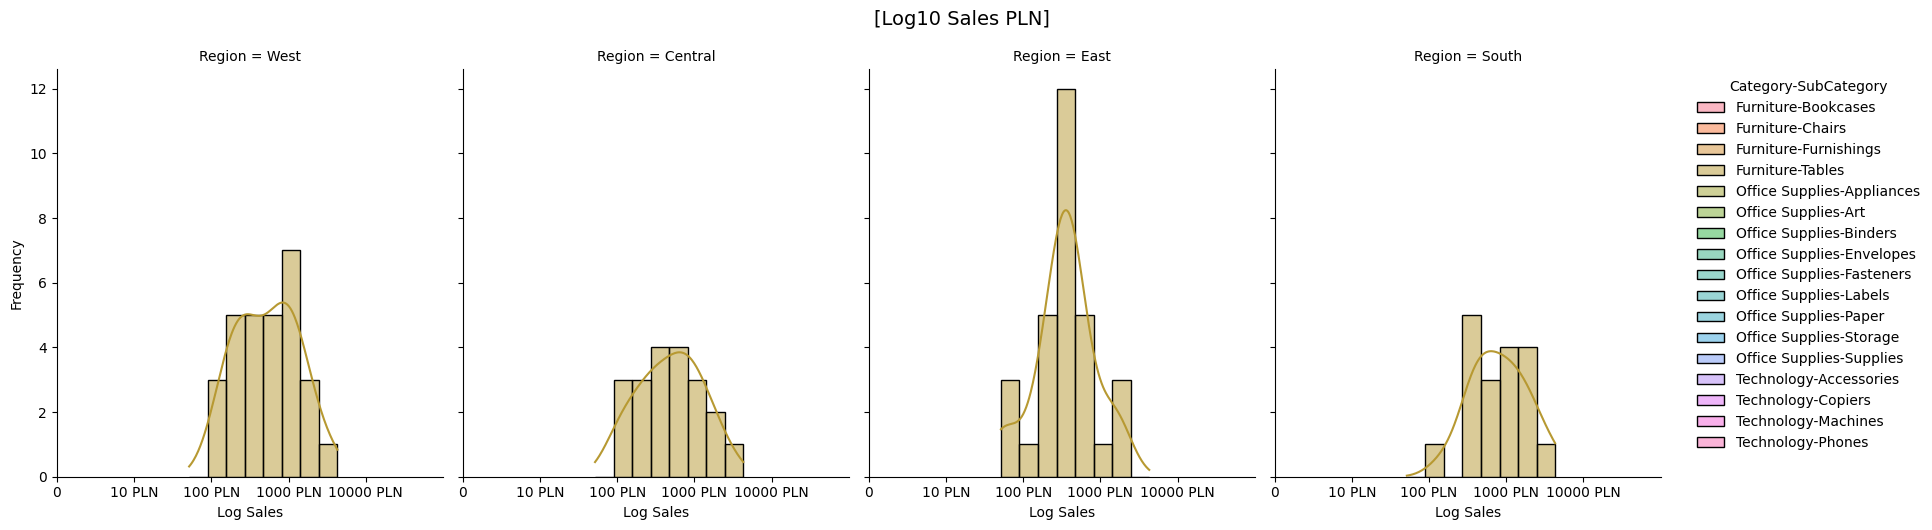

12 Office Supplies-Storage


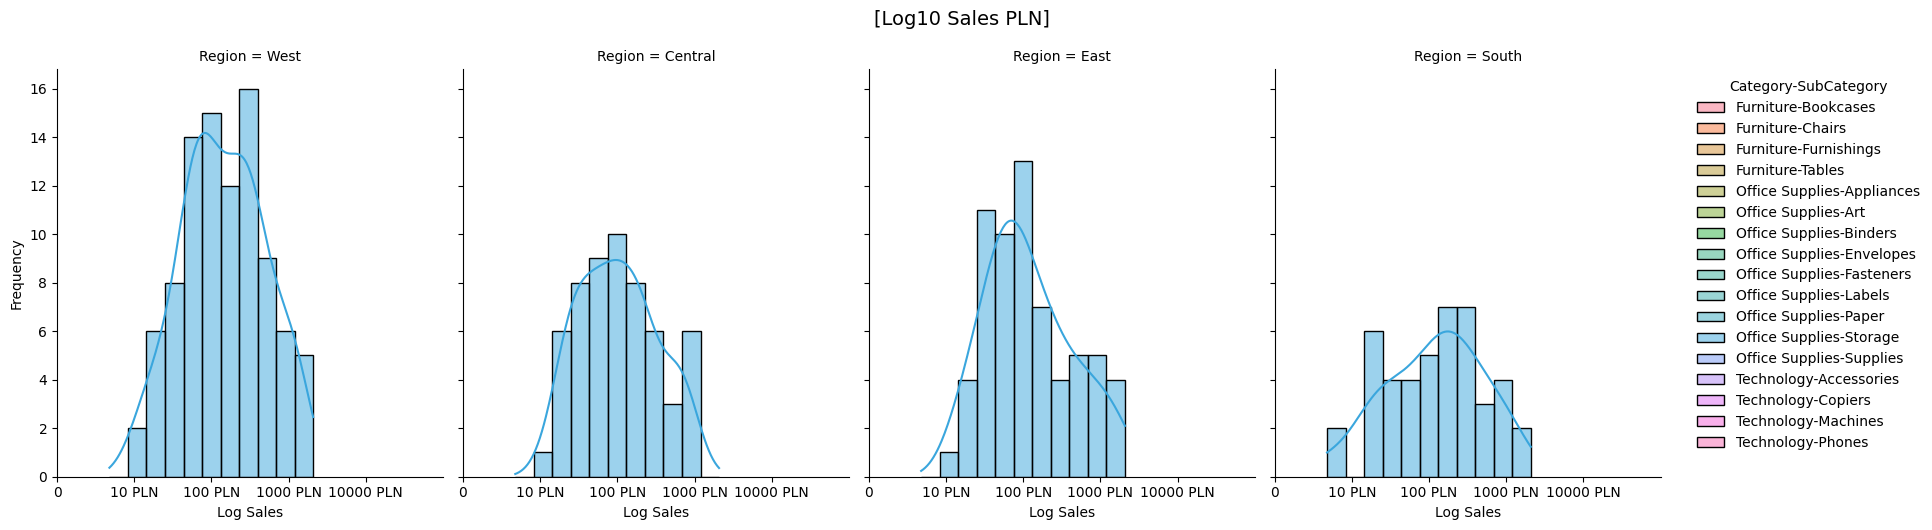

13 Office Supplies-Labels


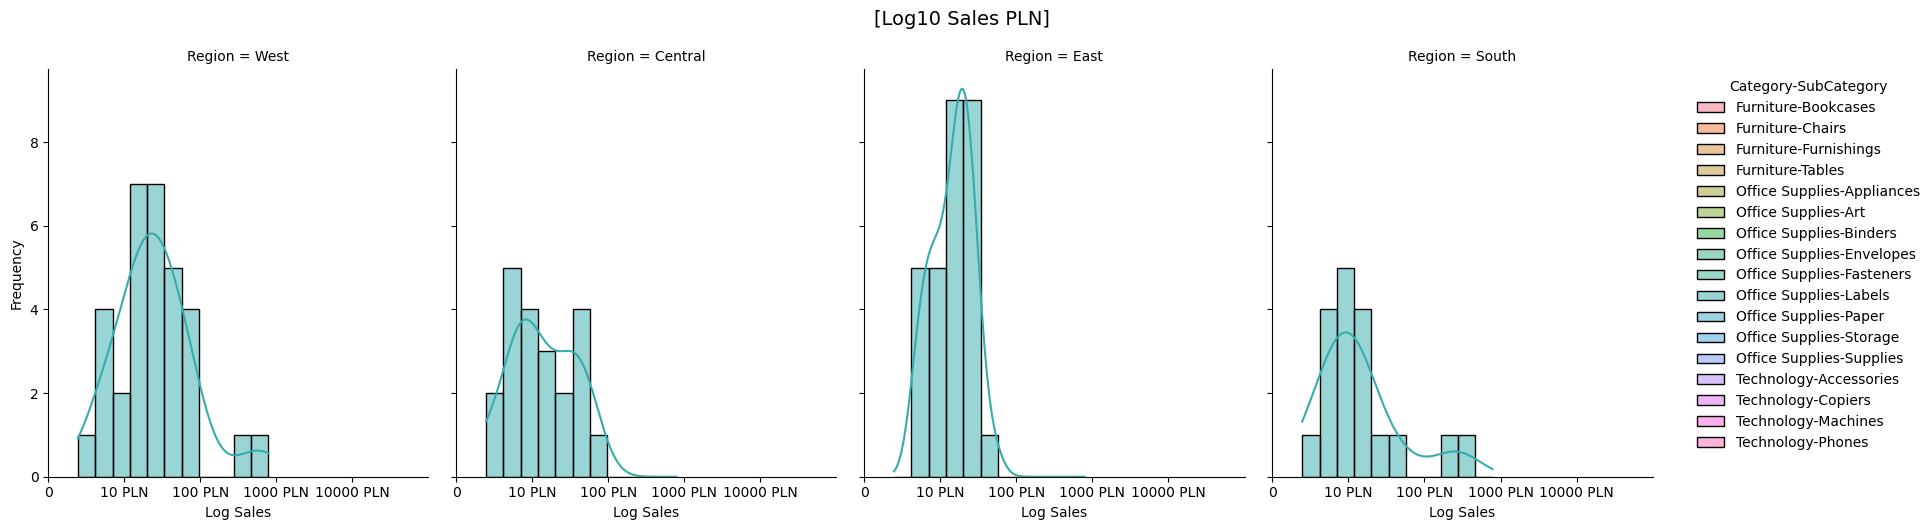

14 Office Supplies-Supplies


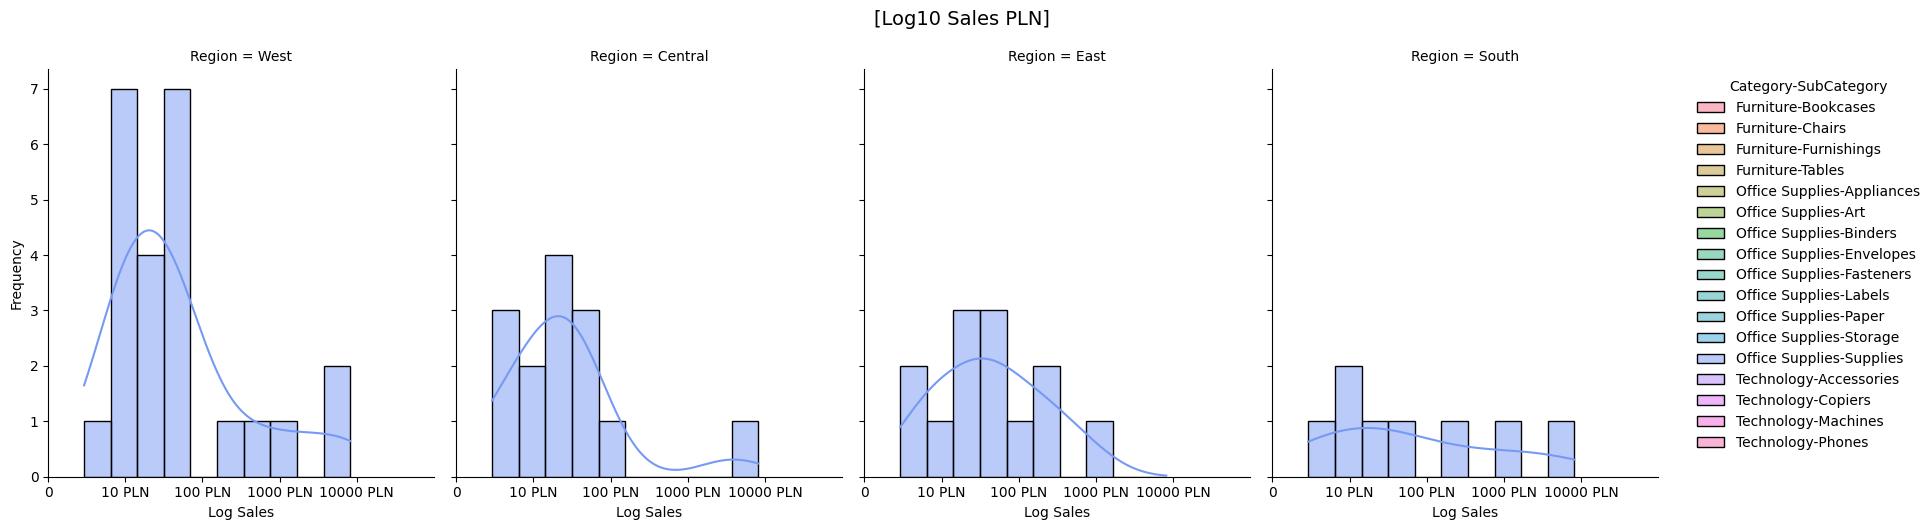

15 Furniture-Bookcases


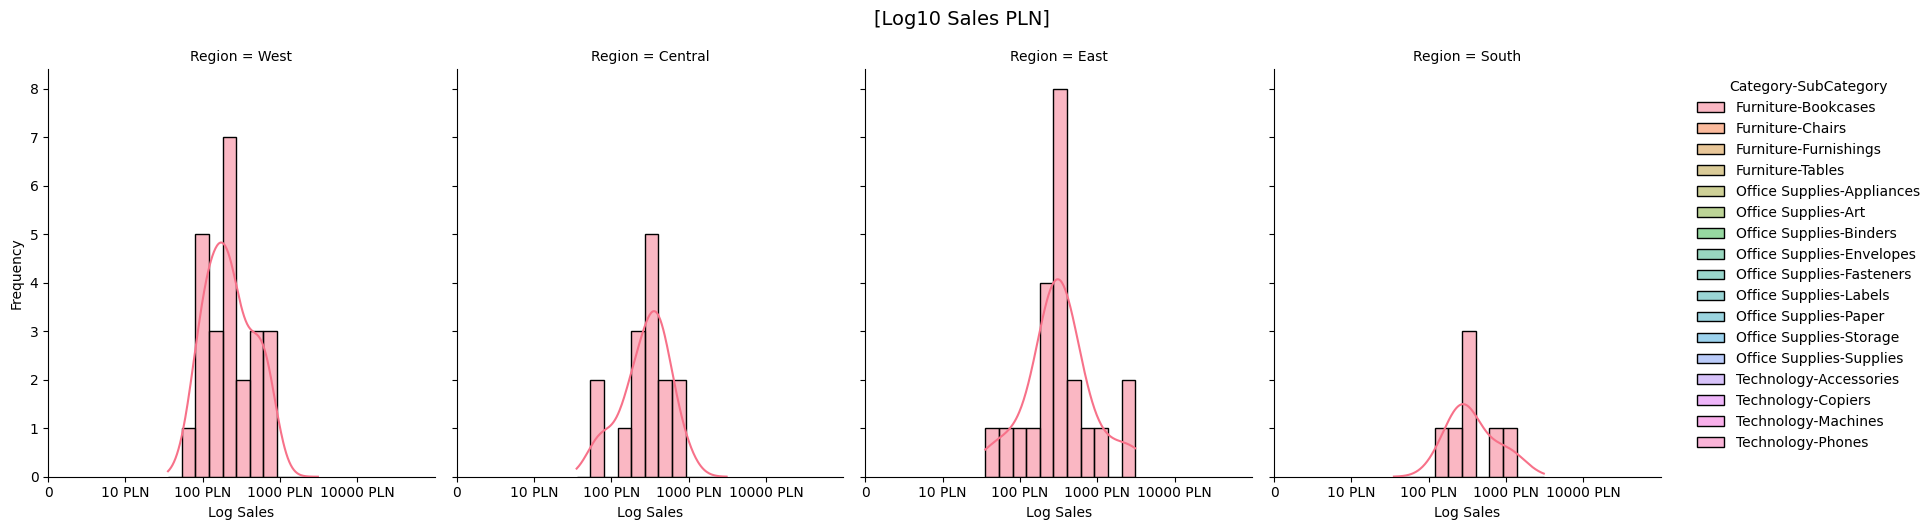

16 Technology-Machines


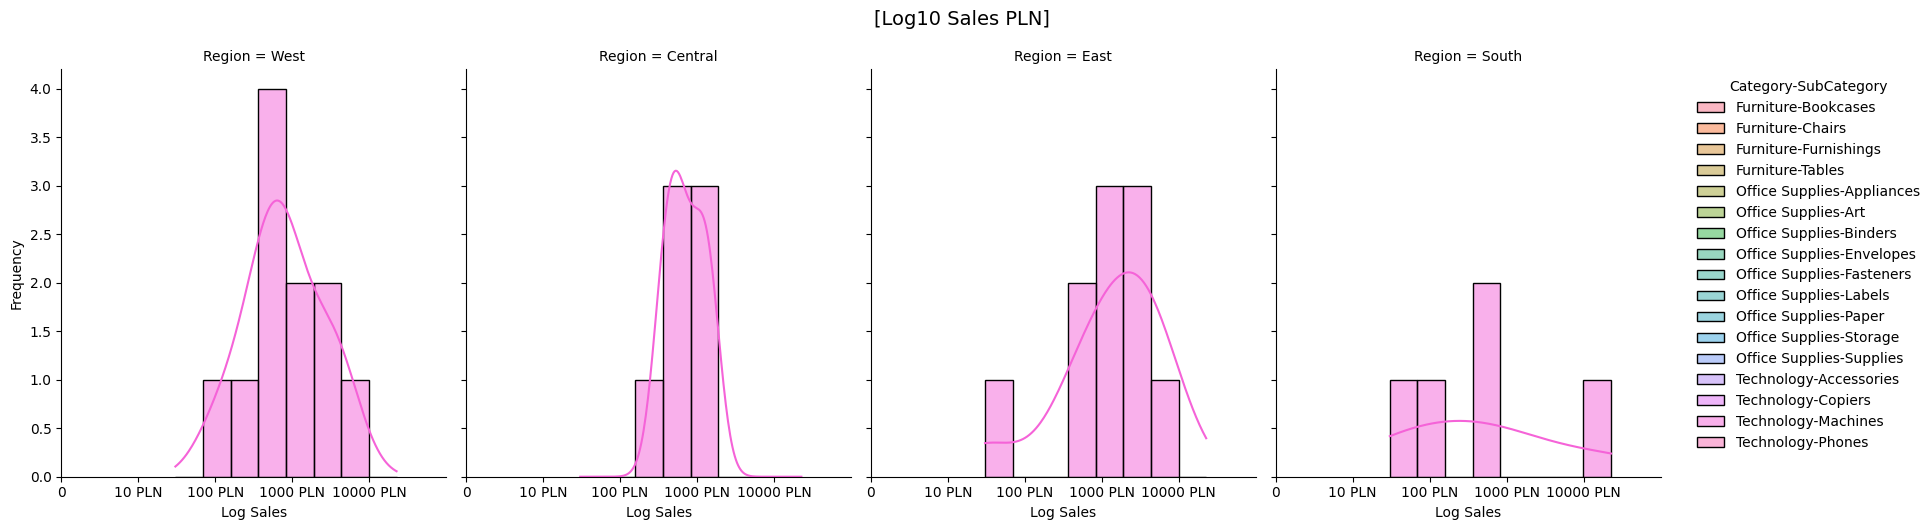

In [164]:
for c, cat in sorted(enumerate(df_sample["Category-SubCategory"].unique())):
    print(c, cat)
    # Create a histogram with groupings based on Order Year
    g = sns.displot(data=df_sample[df_sample["Category-SubCategory"] == cat],
                    x="Log Sales", hue="Category-SubCategory", kde=True, hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85)

    # Customize the plot
    g.set(xlim=(0, 5), xlabel="Log Sales", ylabel="Frequency")
    g.fig.suptitle(f"[Log10 Sales PLN]", fontsize=14, y=1.05)

    # Set the x-axis ticks to [0, 10, 100, 1000]
    g.set(xticks=[0, 1, 2, 3, 4], xticklabels=["0", "10 PLN", "100 PLN", "1000 PLN", "10000 PLN"])
    # g.axes[0][0].xaxis.set_major_formatter(ticker.ScalarFormatter())

    # Show the plot
    plt.show()

# BOX PLOTS

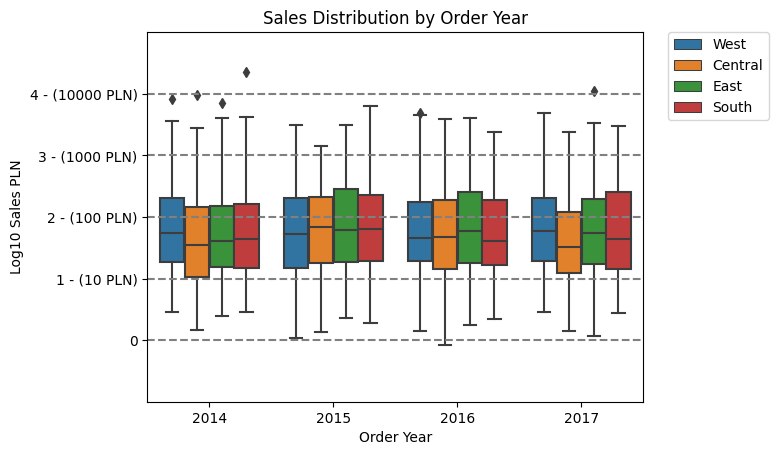

In [195]:
# Define the order of years
year_order = sorted(df_sample["Order Year"].unique())

# Create a box plot with groupings based on Order Year
g = sns.boxplot(data=df_sample, x="Order Year", y="Log Sales", hue="Region", order=year_order)

# Customize the plot
g.set(ylim=(-1, 5), xlabel="Order Year", ylabel="Log10 Sales PLN", title="Sales Distribution by Order Year")

g.set(yticks=[0, 1, 2, 3, 4], yticklabels=["0", "1 - (10 PLN)", "2 - (100 PLN)", "3 - (1000 PLN)", "4 - (10000 PLN)"])
# Move the legend outside the chart box
# Add horizontal lines at each ytick
yticks = plt.yticks()[0]
for ytick in yticks:
    plt.axhline(ytick, color='gray', linestyle='--')

# Move the legend outside the chart box
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

2014
2015
2016
2017


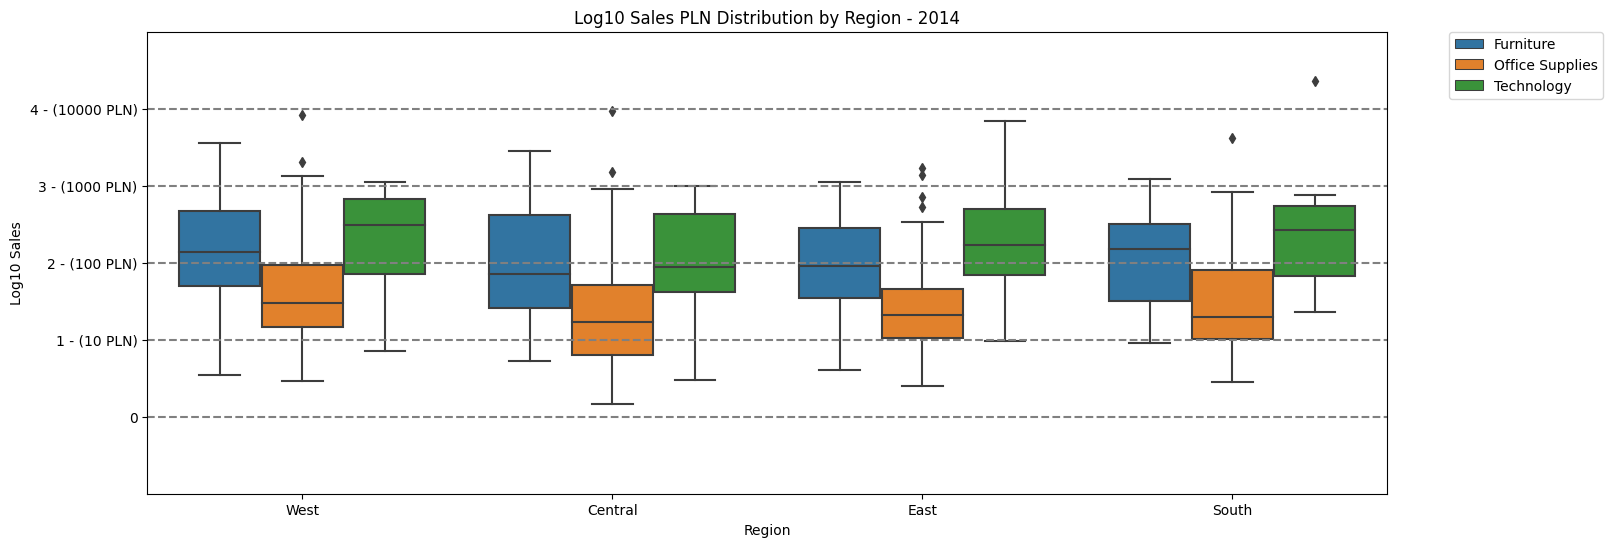

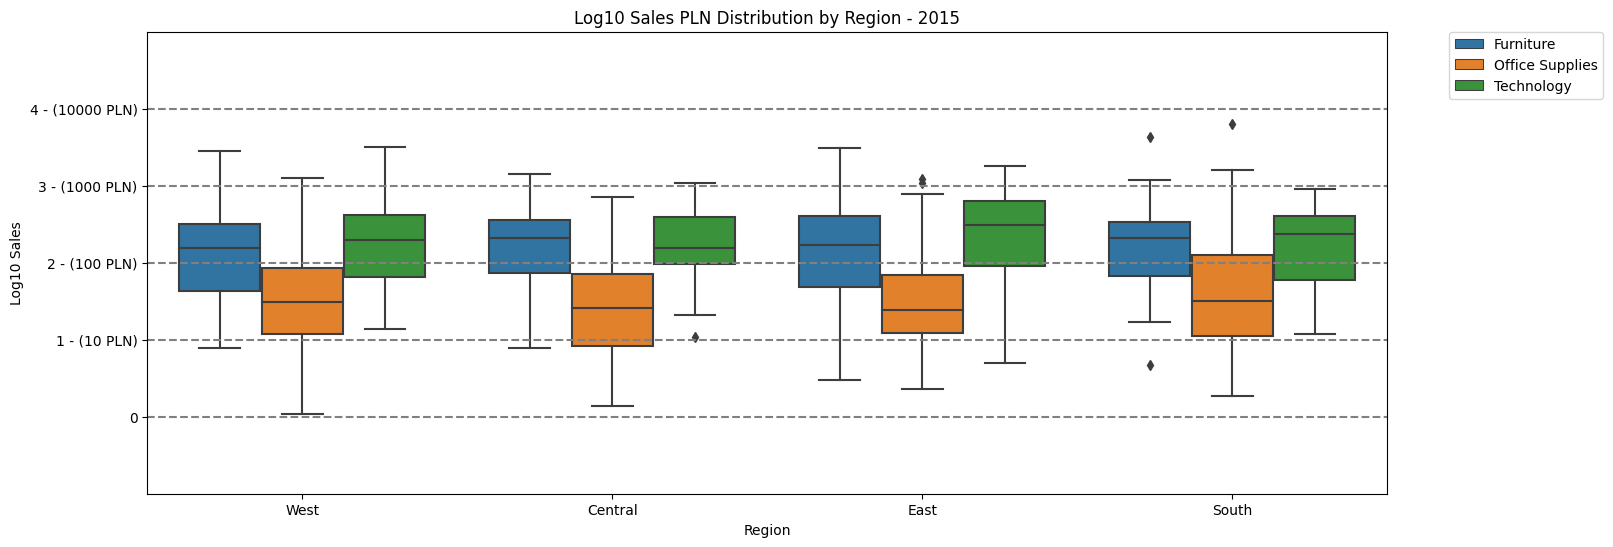

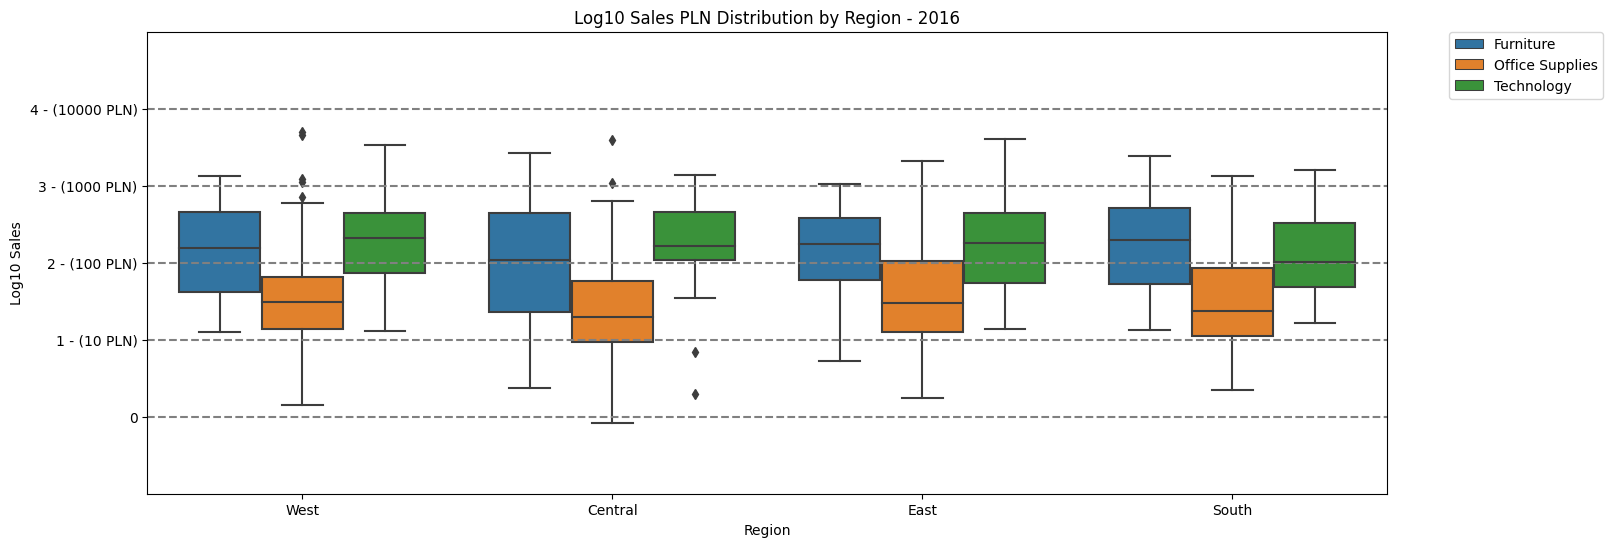

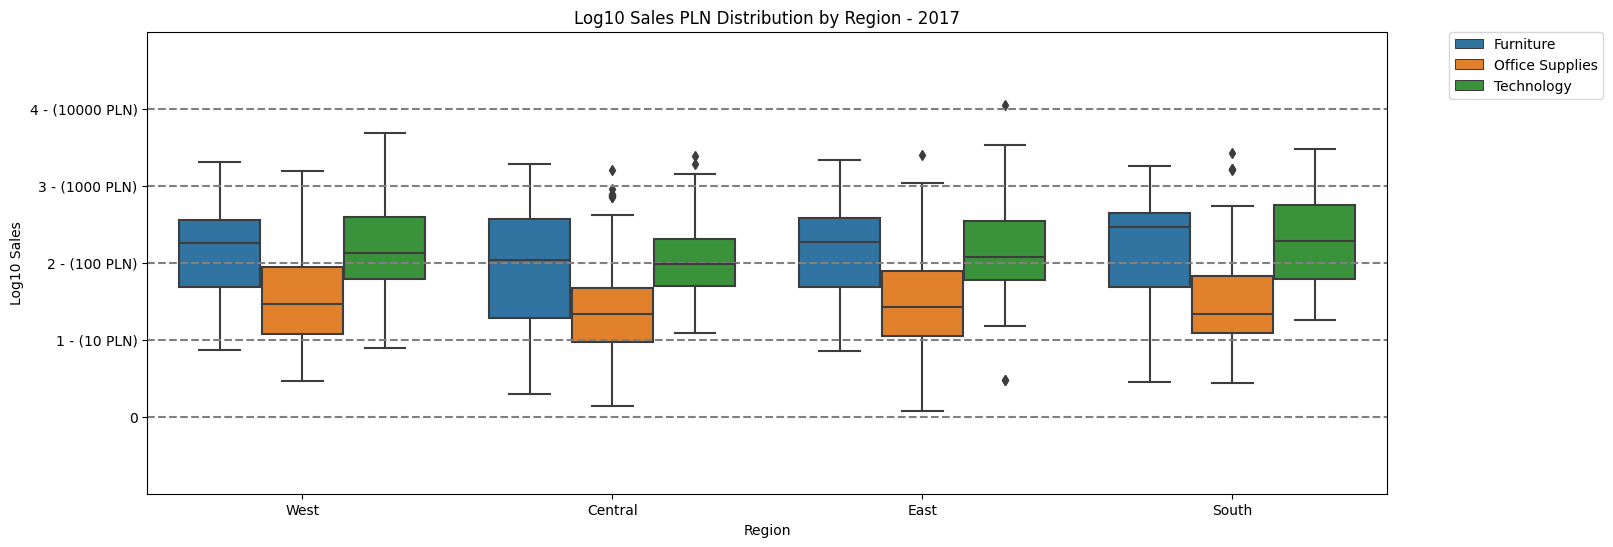

In [188]:
# # Define the order of years
# year_order = sorted(df_sample["Order Year"].unique())
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    
    # Set the figure size
    plt.figure(figsize=(16, 6))

    # Create a box plot with groupings based on Order Year
    g = sns.boxplot(data=df_sample[df_sample["Order Year"] == v], x="Region", y="Log Sales", hue="Category", order=COL_ORDER, hue_order=X_ORDER)

    # Customize the plot
    g.set(ylim=(-1, 5), xlabel="Region", ylabel="Log10 Sales", title=f"Log10 Sales PLN Distribution by Region - {v}")
    g.set(yticks=[0, 1, 2, 3, 4], yticklabels=["0", "1 - (10 PLN)", "2 - (100 PLN)", "3 - (1000 PLN)", "4 - (10000 PLN)"])
    # Add horizontal lines at each ytick
    yticks = plt.yticks()[0]
    for ytick in yticks:
        plt.axhline(ytick, color='gray', linestyle='--')
    # Move the legend outside the chart box
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

2014
2015
2016
2017


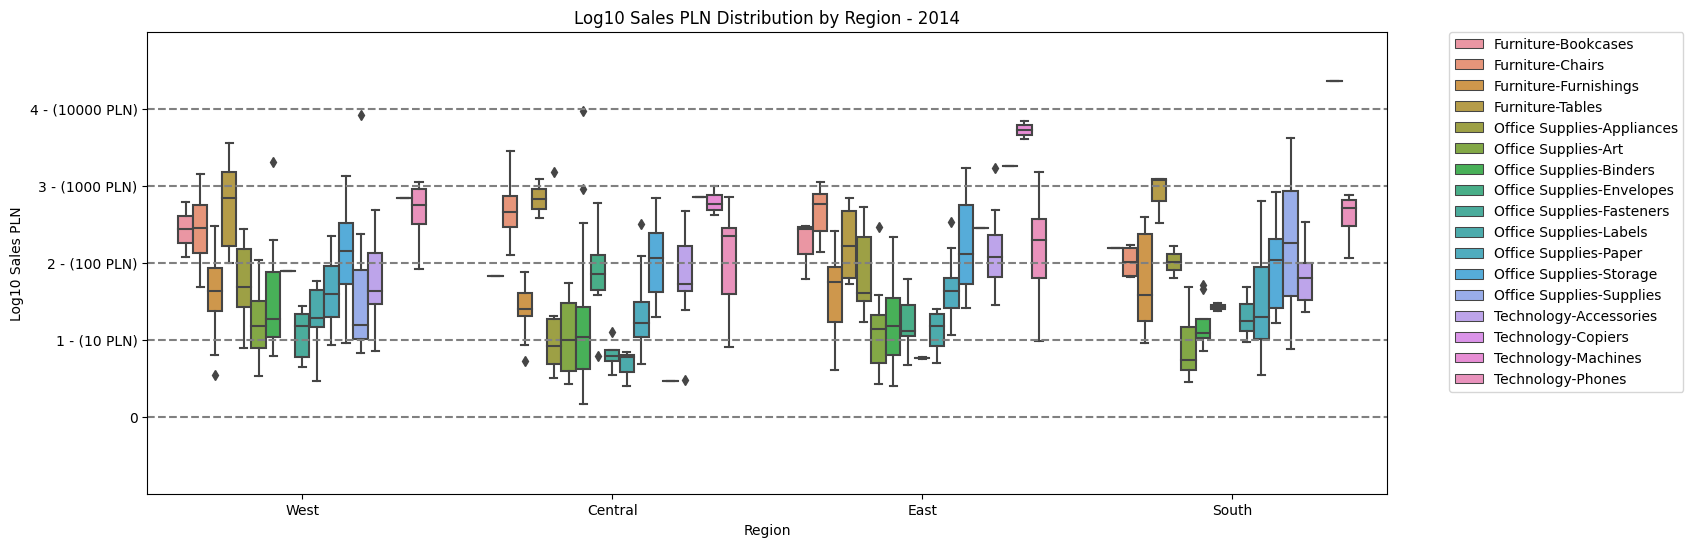

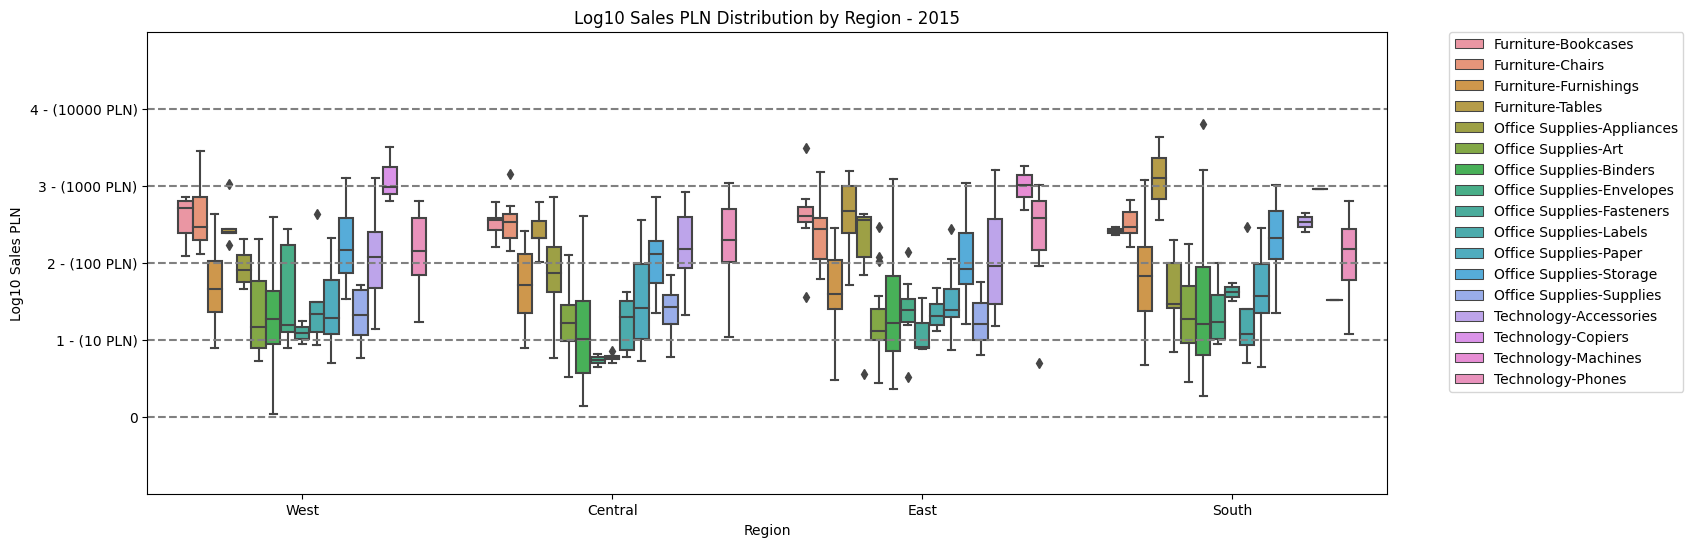

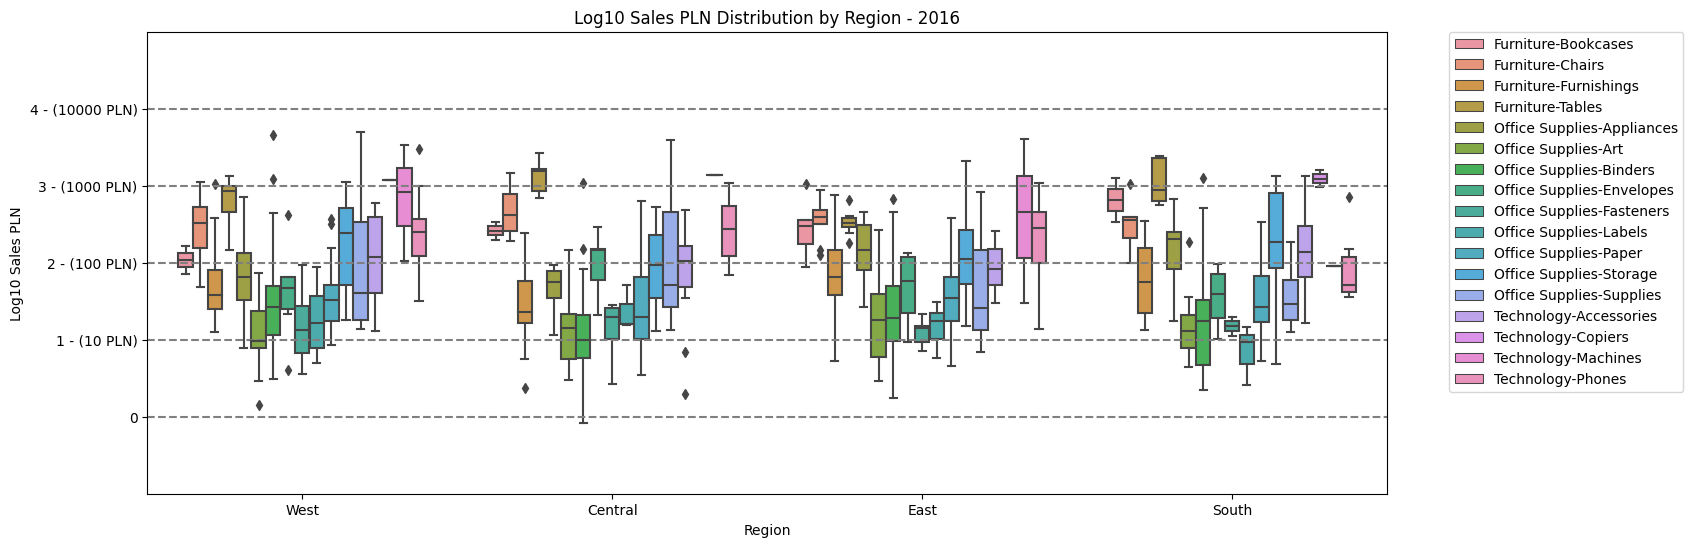

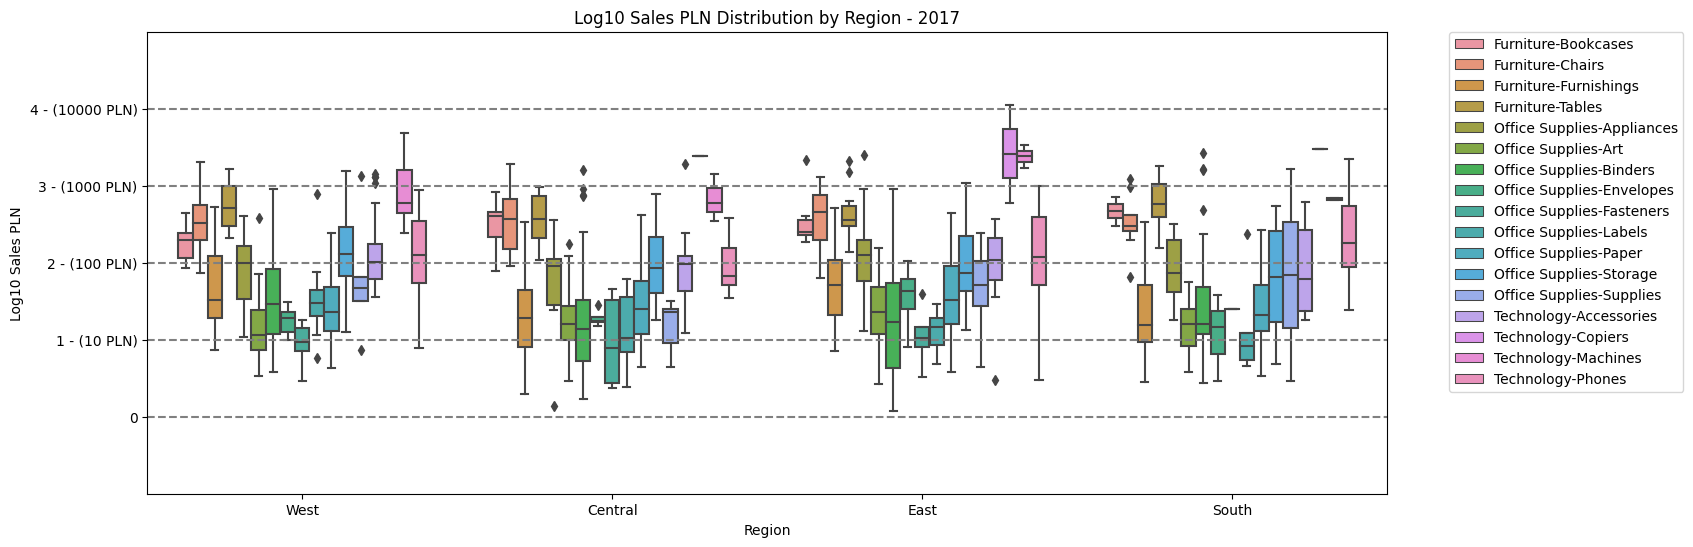

In [189]:
# # Define the order of years
# year_order = sorted(df_sample["Order Year"].unique())
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    
    # # Define the order of years
    # year_order = sorted(df_sample["Order Year"].unique())

    # Set the figure size
    plt.figure(figsize=(16, 6))

    # Create a box plot with groupings based on Order Year
    g = sns.boxplot(data=df_sample[df_sample["Order Year"] == v], x="Region", y="Log Sales", hue="Category-SubCategory", order=COL_ORDER, hue_order=HUE_ORDER)

    # Customize the plot
    g.set(ylim=(-1, 5), xlabel="Region", ylabel="Log10 Sales PLN", title=f"Log10 Sales PLN Distribution by Region - {v}")
    g.set(yticks=[0, 1, 2, 3, 4], yticklabels=["0", "1 - (10 PLN)", "2 - (100 PLN)", "3 - (1000 PLN)", "4 - (10000 PLN)"])
    # Move the legend outside the chart box
    # Add horizontal lines at each ytick
    yticks = plt.yticks()[0]
    for ytick in yticks:
        plt.axhline(ytick, color='gray', linestyle='--')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# SWARM PLOTS

## Winsorized Sales

Text(0.5, 1.05, '[Winsorized Sales]')

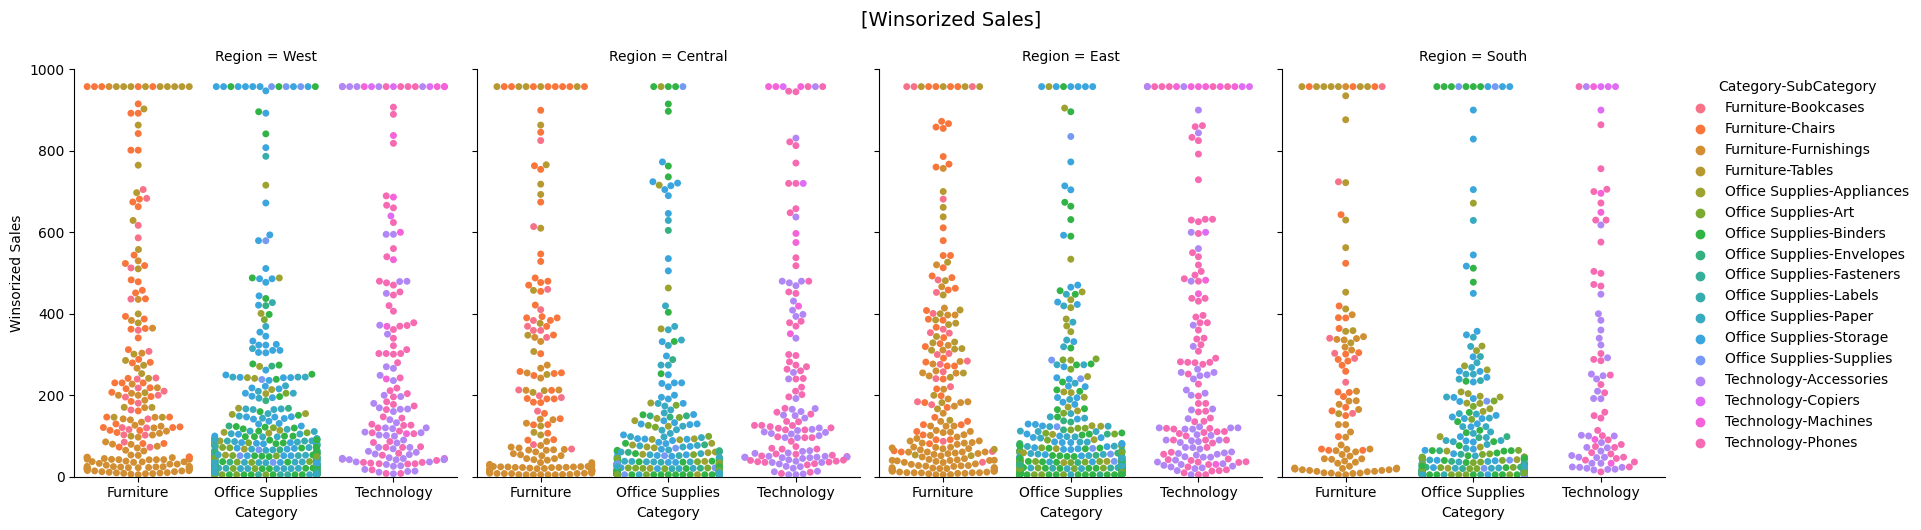

In [107]:
g = sns.catplot(
    data=df_sample, kind="swarm",
    x="Category", order=X_ORDER, y="Winsorized Sales", hue="Category-SubCategory", hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85
)
g.set(ylim=(0, 1000))
g.fig.suptitle(f"[Winsorized Sales]", fontsize=14, y=1.05)

2014
2015
2016
2017


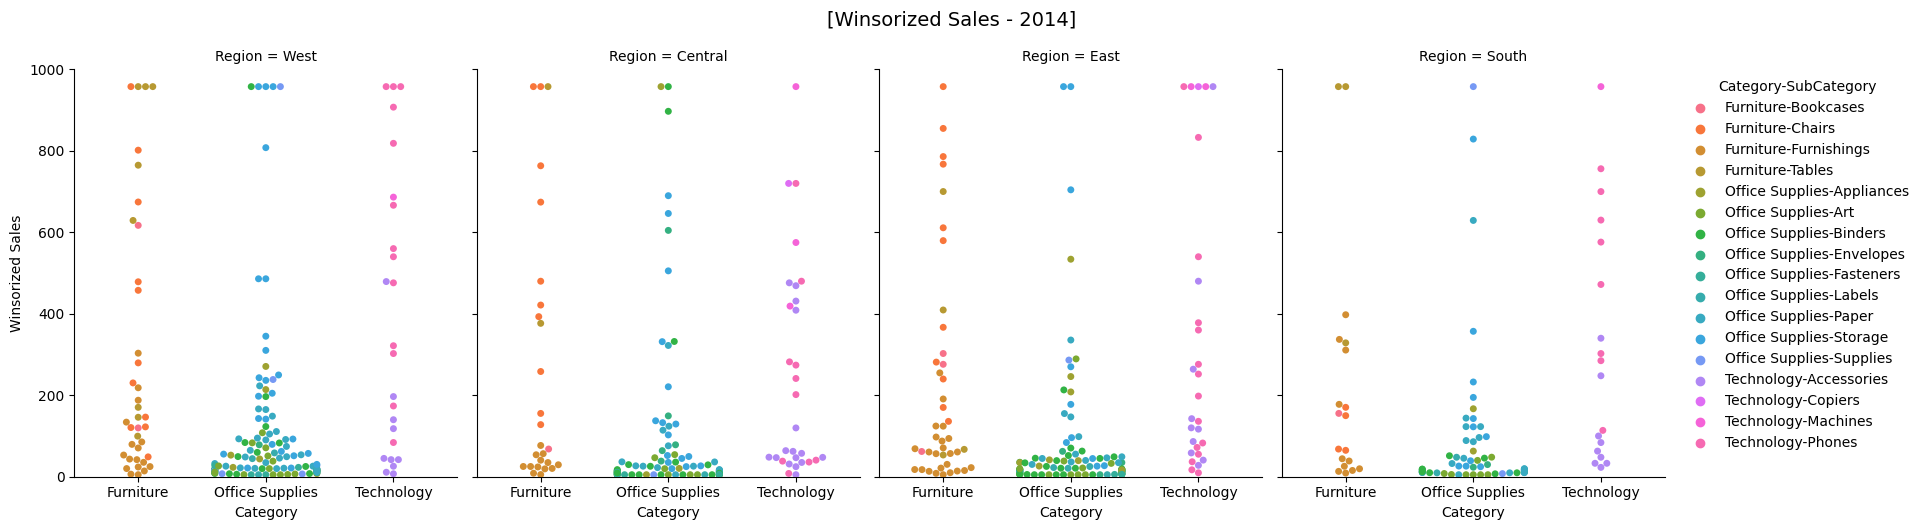

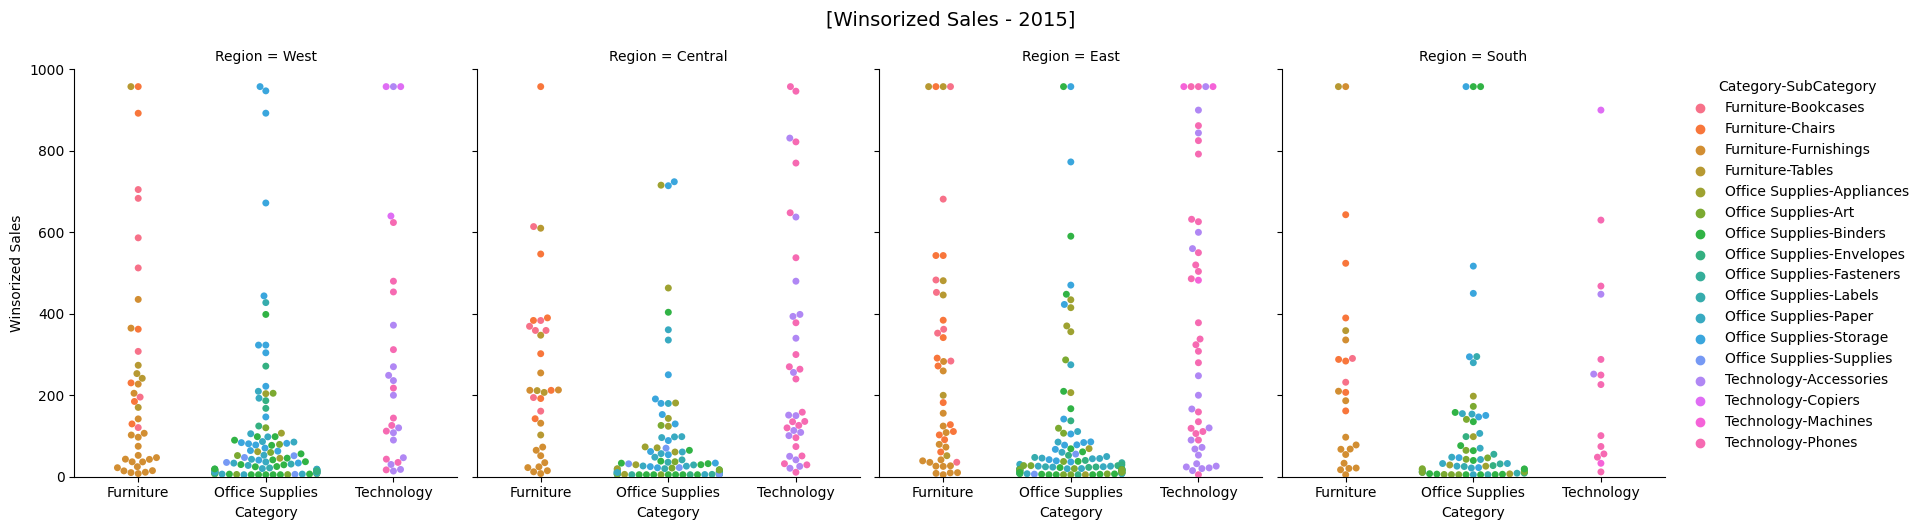

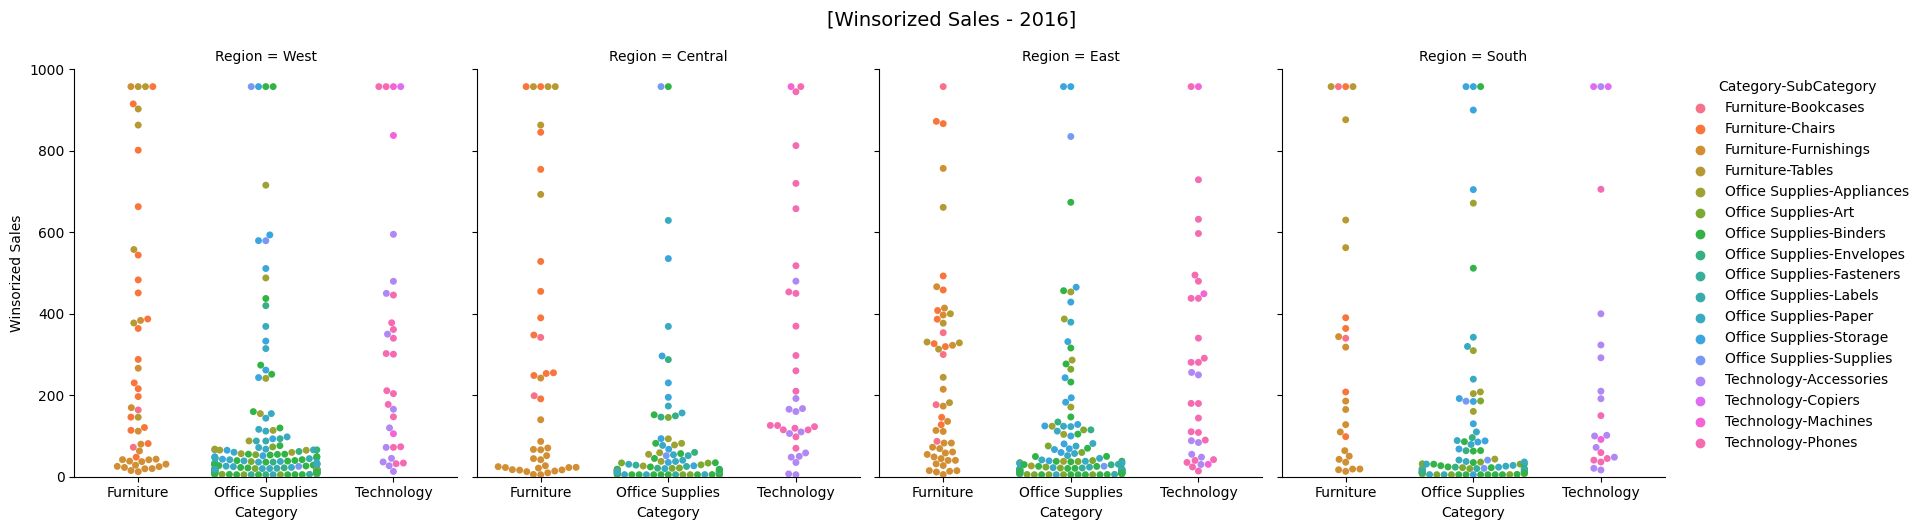

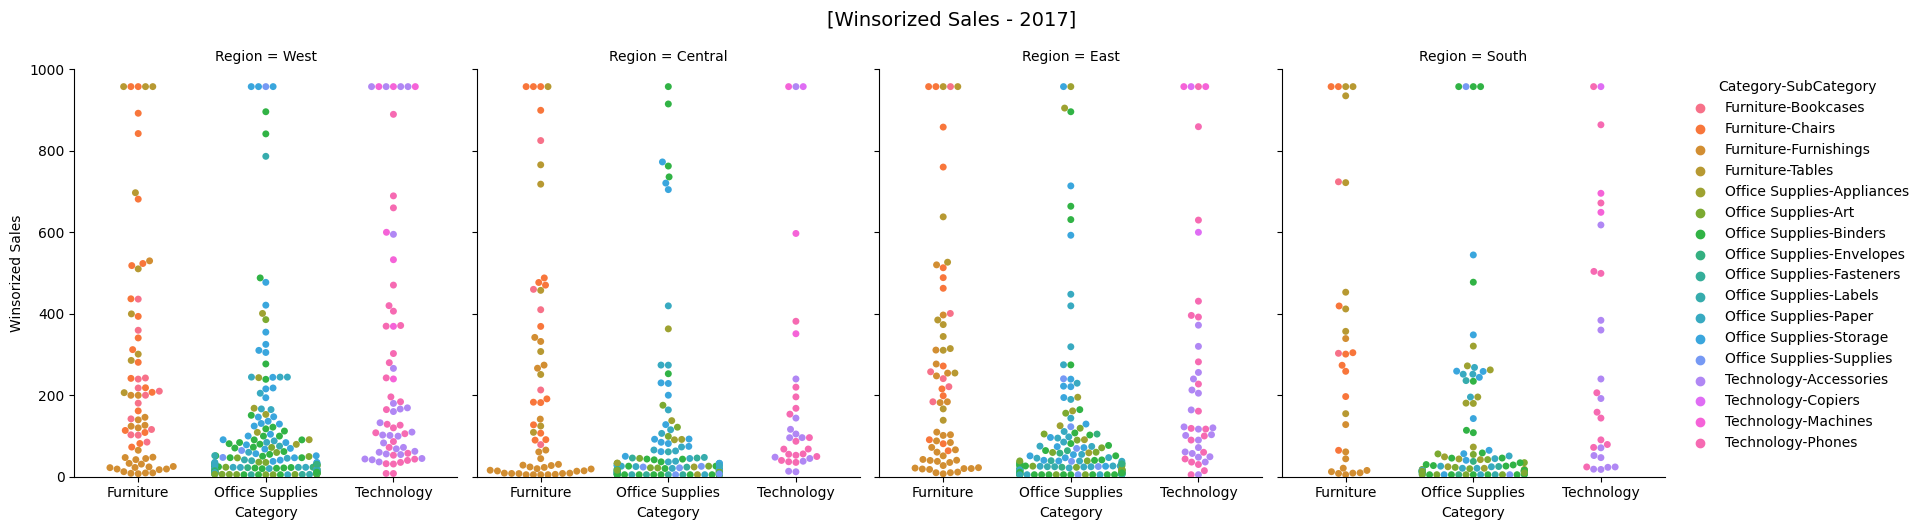

In [111]:
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    g = sns.catplot(
        data=df_sample[df_sample["Order Year"] == v], kind="swarm",
        x="Category", order=X_ORDER, y="Winsorized Sales", hue="Category-SubCategory", hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85
    )
    g.set(ylim=(0, 1000))
    g.fig.suptitle(f"[Winsorized Sales - {v}]", fontsize=14, y=1.05)

## Log Sales

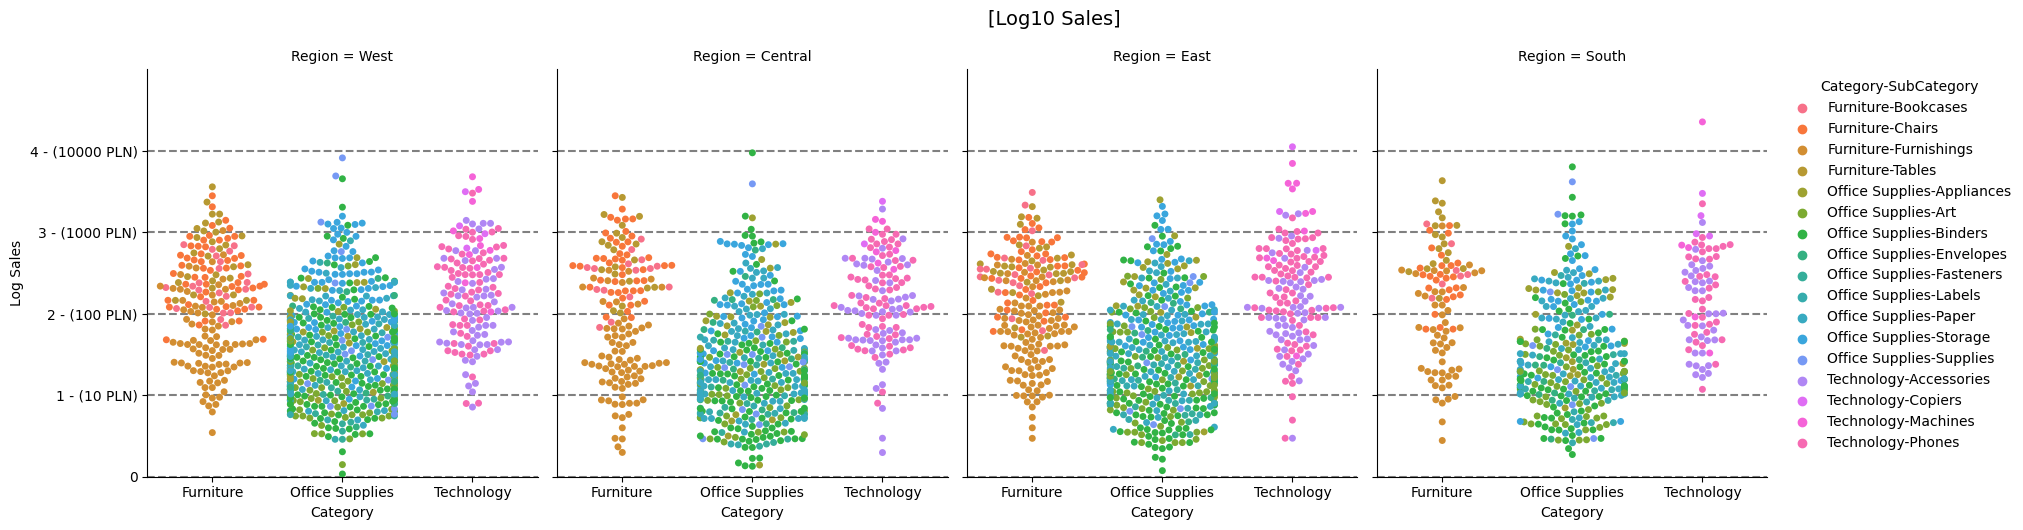

In [202]:
g = sns.catplot(
    data=df_sample, kind="swarm",
    x="Category", order=X_ORDER, y="Log Sales", hue="Category-SubCategory", hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85
)
g.set(ylim=(0, 5))
g.fig.suptitle(f"[Log10 Sales]", fontsize=14, y=1.05)

g.set(yticks=[0, 1, 2, 3, 4], yticklabels=["0", "1 - (10 PLN)", "2 - (100 PLN)", "3 - (1000 PLN)", "4 - (10000 PLN)"])
# Move the legend outside the chart box
# Add horizontal lines at each ytick
for ax in g.axes.flat:
    yticks = ax.get_yticks()
    for ytick in yticks:
        ax.axhline(ytick, color='gray', linestyle='--')


2014
2015
2016
2017


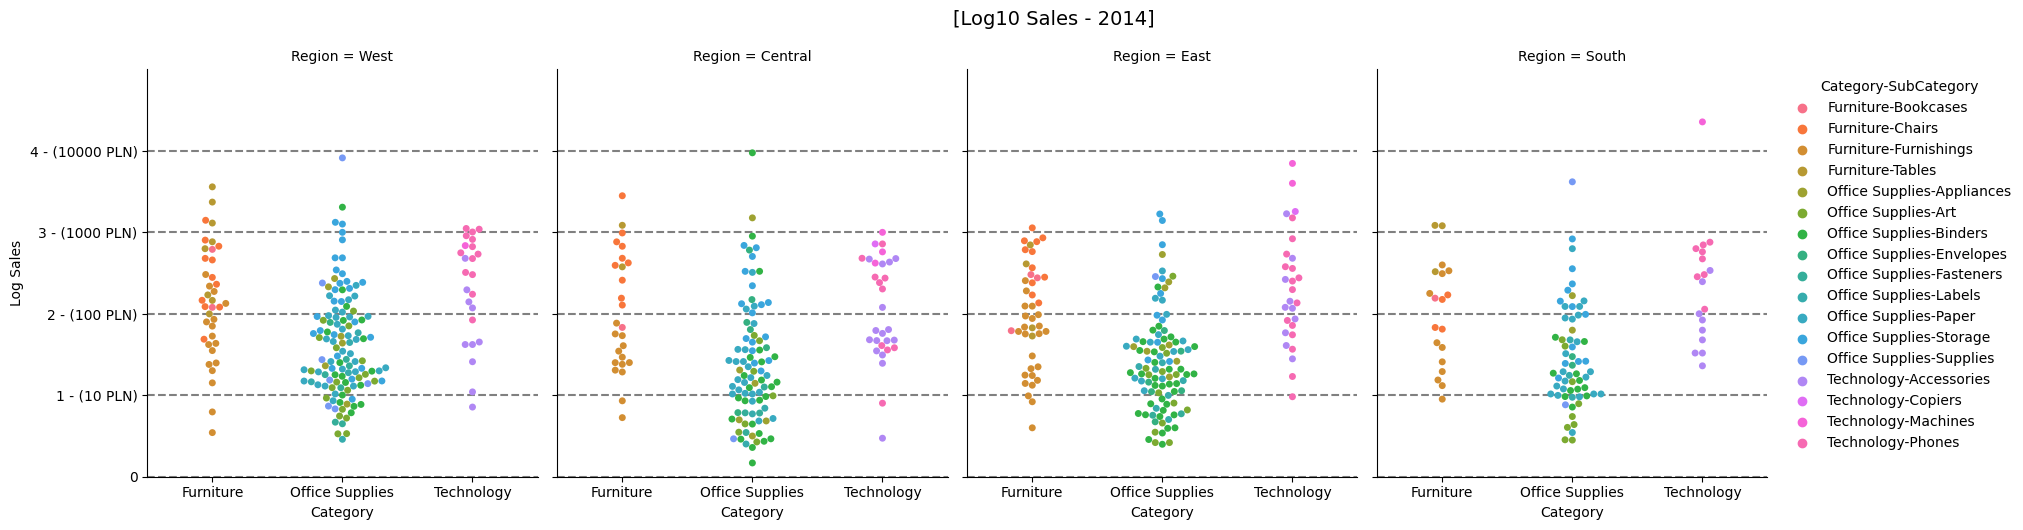

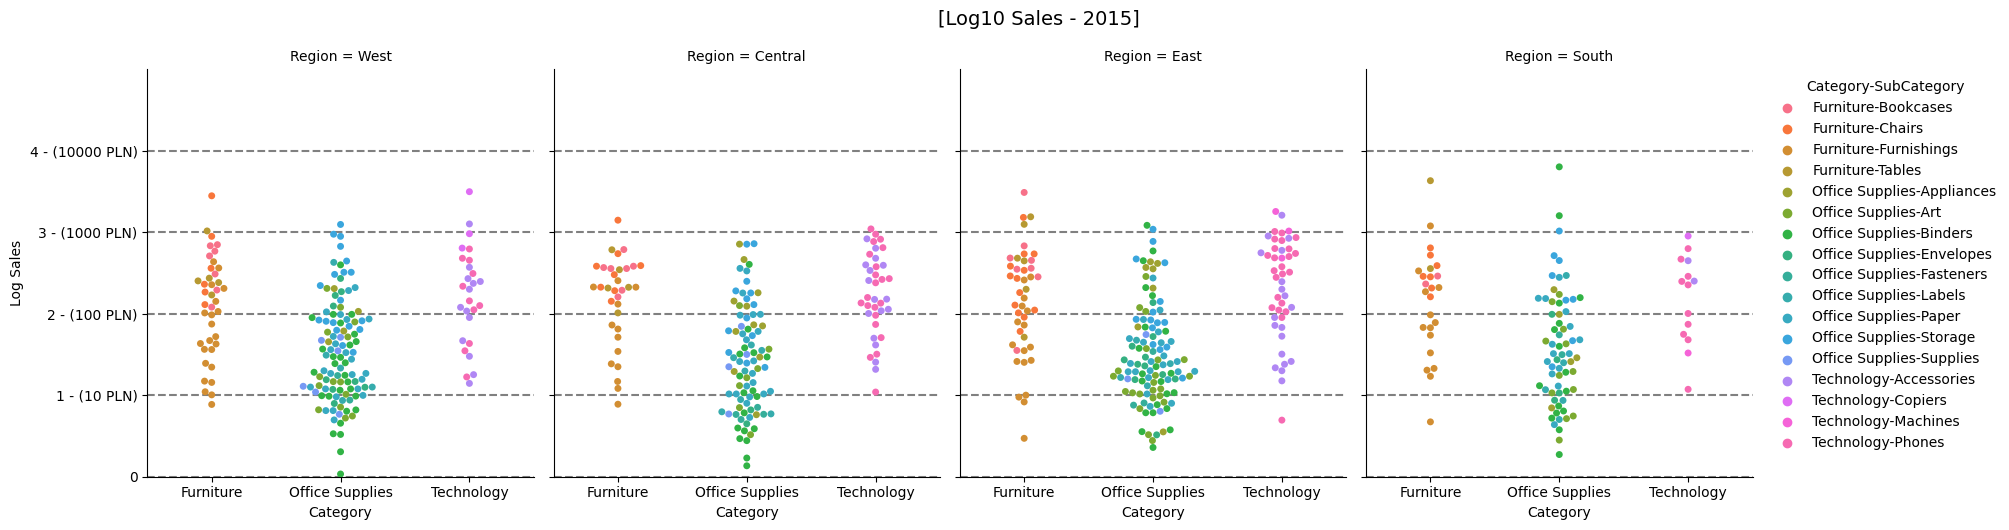

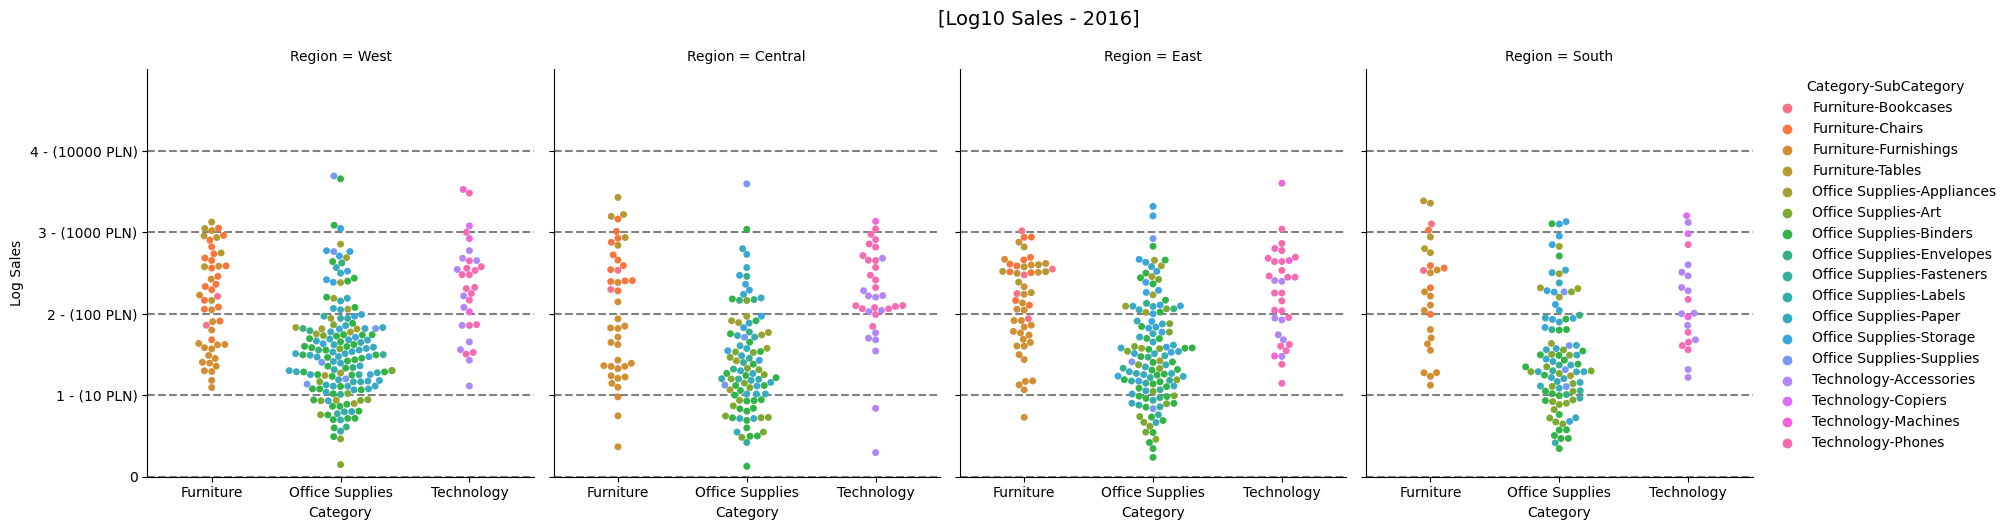

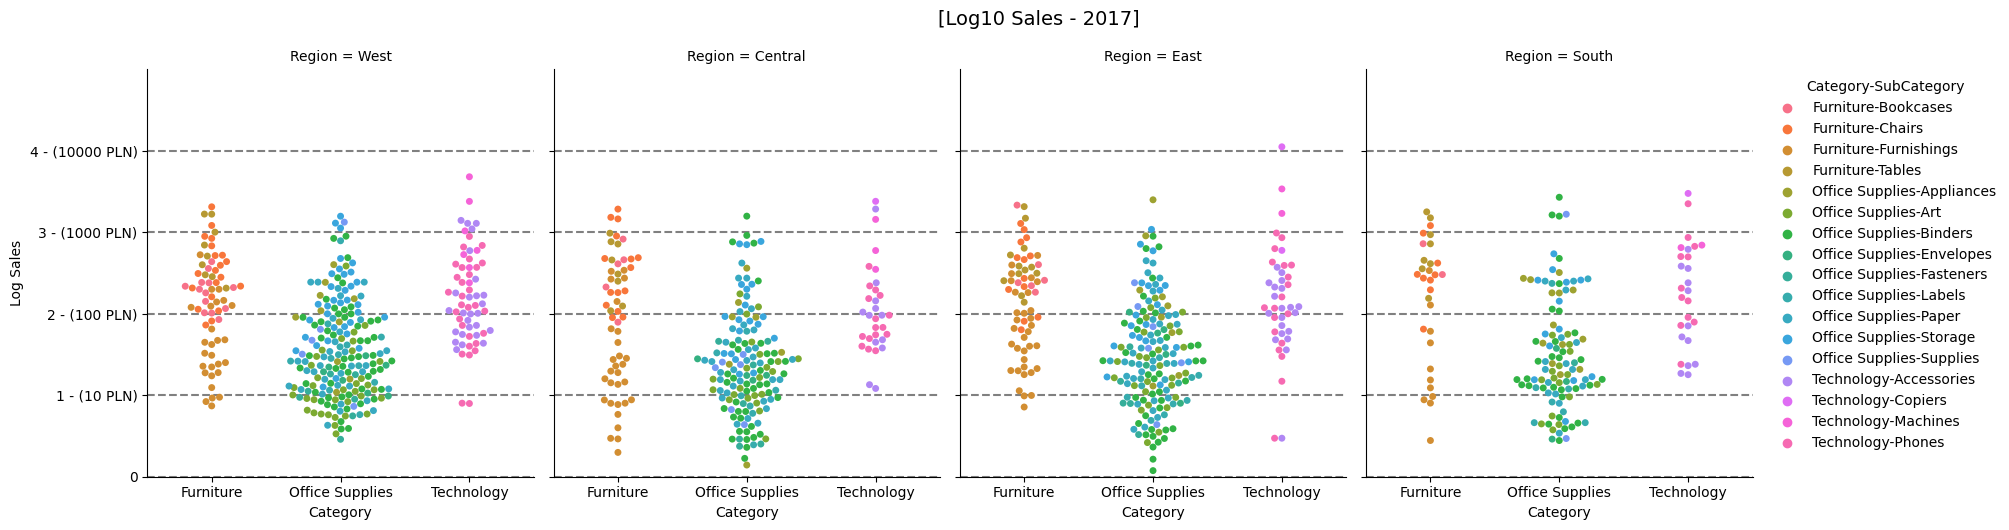

In [203]:
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    g = sns.catplot(
        data=df_sample[df_sample["Order Year"] == v], kind="swarm",
        x="Category", order=X_ORDER, y="Log Sales", hue="Category-SubCategory", hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85
    )
    g.set(ylim=(0, 5))
    g.fig.suptitle(f"[Log10 Sales - {v}]", fontsize=14, y=1.05)
    
    g.set(yticks=[0, 1, 2, 3, 4], yticklabels=["0", "1 - (10 PLN)", "2 - (100 PLN)", "3 - (1000 PLN)", "4 - (10000 PLN)"])
    # Move the legend outside the chart box
    # Add horizontal lines at each ytick
    for ax in g.axes.flat:
        yticks = ax.get_yticks()
        for ytick in yticks:
            ax.axhline(ytick, color='gray', linestyle='--')

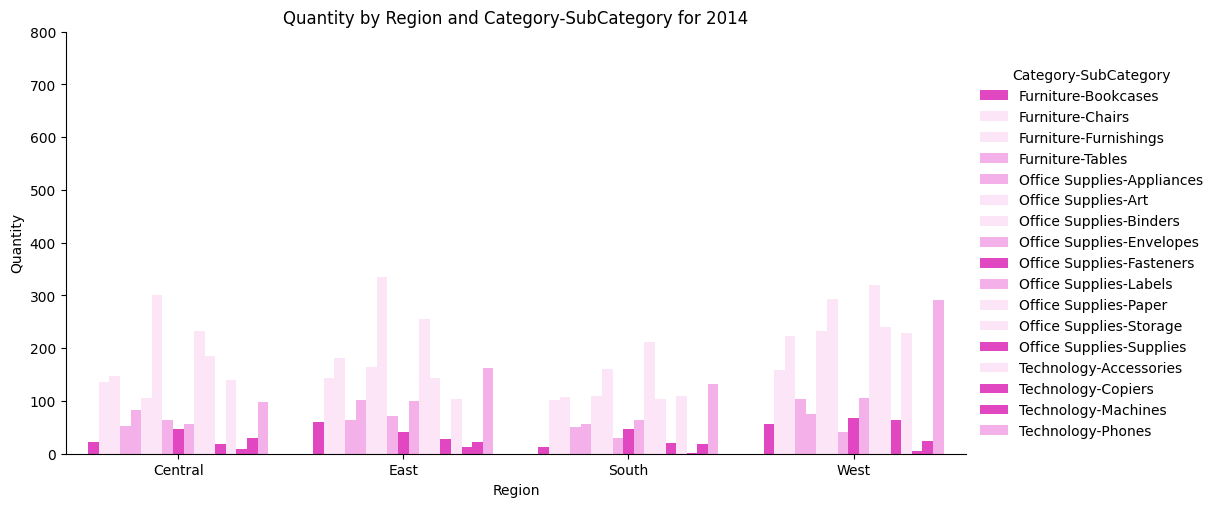

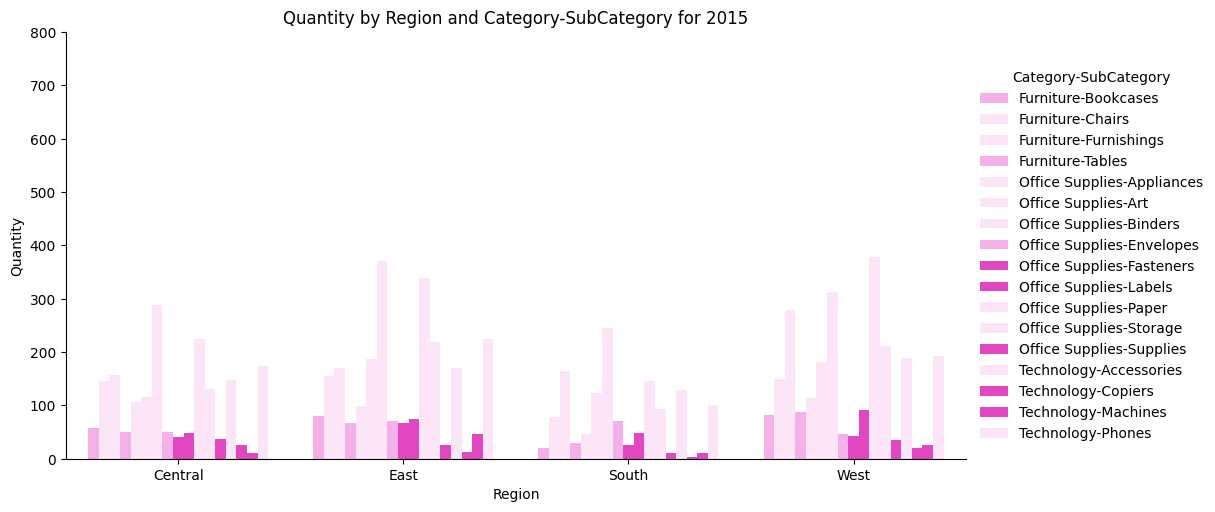

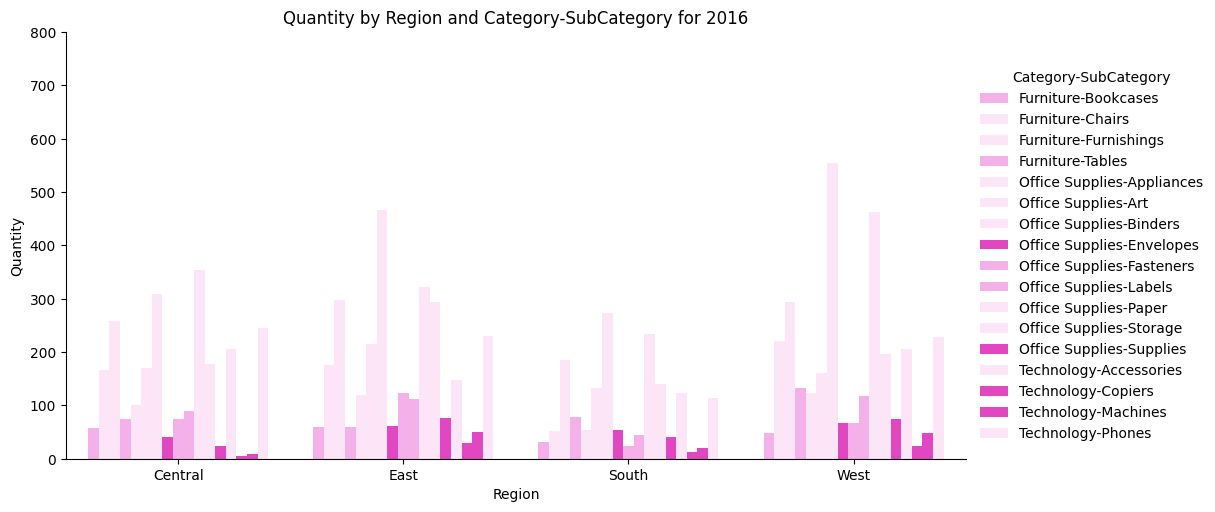

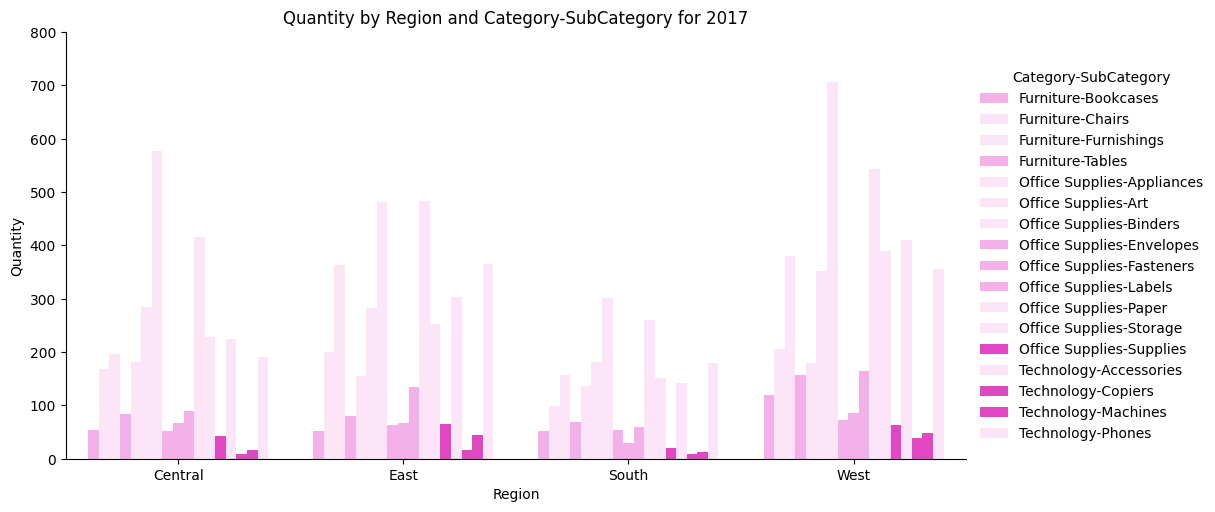

In [362]:
import seaborn as sns

# Define the function to generate a custom color palette
def color_palette(data, variable):
    colors = []
    for value in data[variable]:
        if value < 50:
            colors.append('#FA2DD0') # Light red
        elif value < 100:
            colors.append('#FFA5F0') # Medium red
        else:
            colors.append('#FFE1FA') # Dark red
    return colors

# Loop through the years and create the bar charts
for year in sorted(df['Order Year'].unique()):
    data = df[df['Order Year'] == year]
    pivot_table = data.groupby(['Region', 'Category-SubCategory']).agg({'Quantity': 'sum', 'Sales': 'sum'}).reset_index()

    # Set the color of the bars based on the Sales column
    my_palette = sns.color_palette(color_palette(pivot_table, 'Quantity'))

    # Plot Sales by Region and SubCategory
    g = sns.catplot(data=pivot_table, x='Region', y='Quantity', hue='Category-SubCategory', hue_order=HUE_ORDER, kind='bar', height=5, aspect=2, palette=my_palette)
    g.set(ylim=(0, 800))
    plt.title(f'Quantity by Region and Category-SubCategory for {year}')
    plt.show()


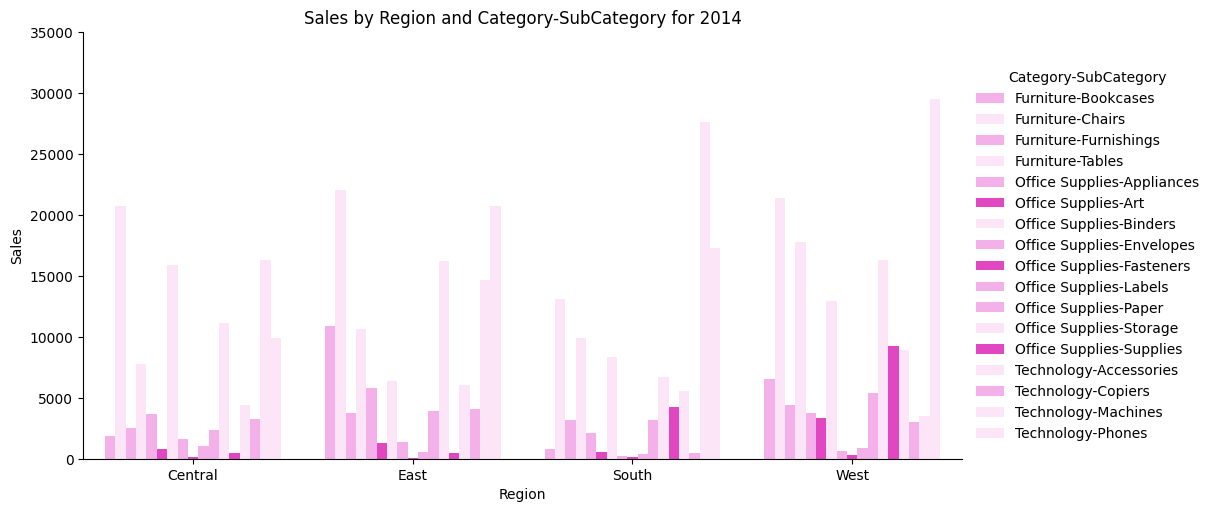

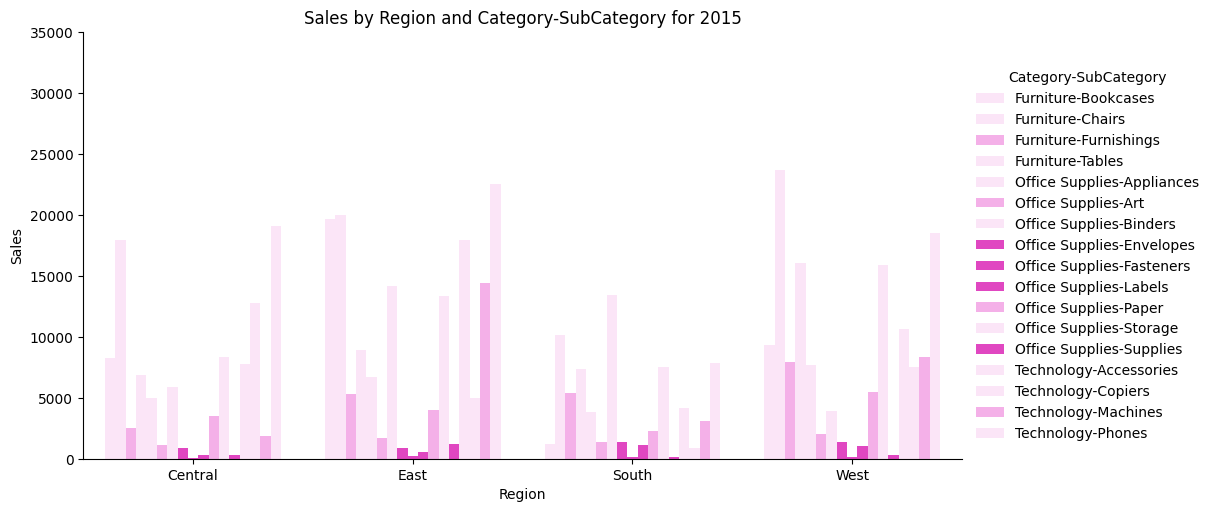

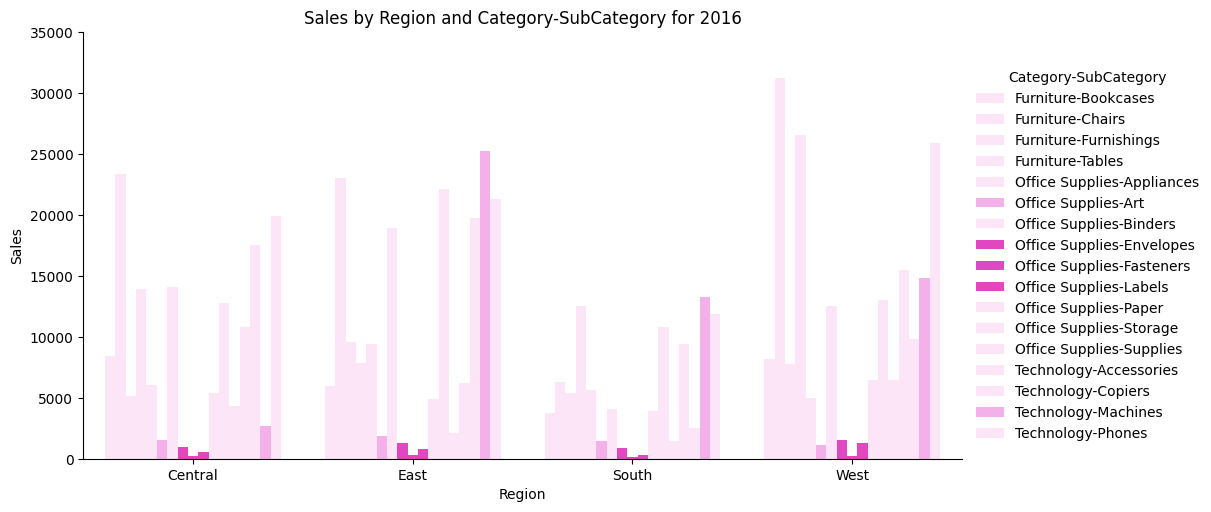

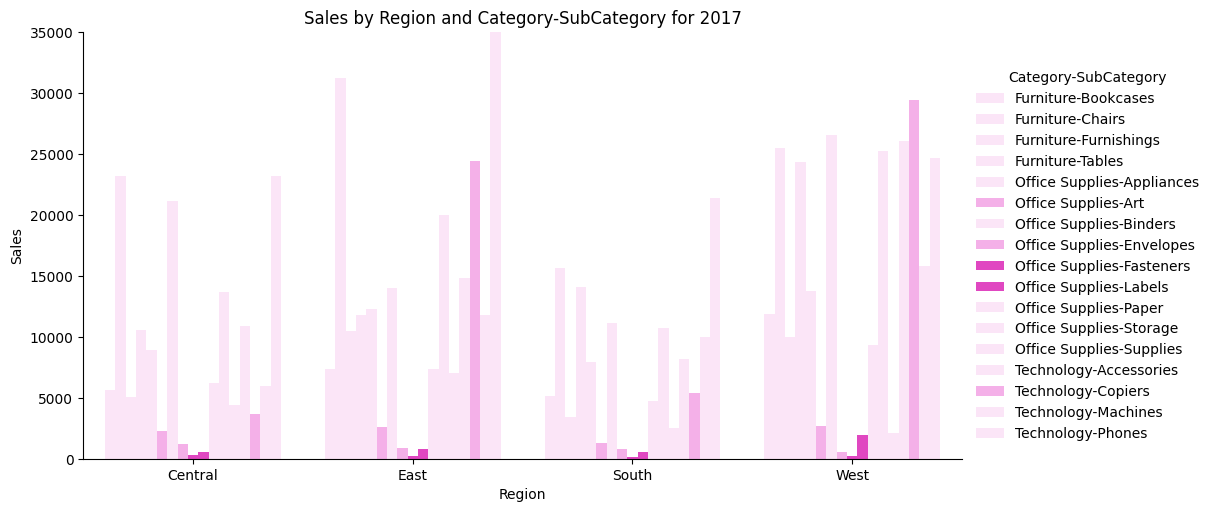

In [363]:
import seaborn as sns

# Define the function to generate a custom color palette
def color_palette(data, variable):
    colors = []
    for value in data[variable]:
        if value < 1000:
            colors.append('#FA2DD0') # Light red
        elif value < 4000:
            colors.append('#FFA5F0') # Medium red
        else:
            colors.append('#FFE1FA') # Dark red
    return colors

# Loop through the years and create the bar charts
for year in sorted(df['Order Year'].unique()):
    data = df[df['Order Year'] == year]
    pivot_table = data.groupby(['Region', 'Category-SubCategory']).agg({'Sales': 'sum'}).reset_index()

    # Set the color of the bars based on the Sales column
    my_palette = sns.color_palette(color_palette(pivot_table, 'Sales'))

    # Plot Sales by Region and SubCategory
    g = sns.catplot(data=pivot_table, x='Region', y='Sales', hue='Category-SubCategory', hue_order=HUE_ORDER, kind='bar', height=5, aspect=2, palette=my_palette)
    g.set(ylim=(0, 35000))
    plt.title(f'Sales by Region and Category-SubCategory for {year}')
    plt.show()


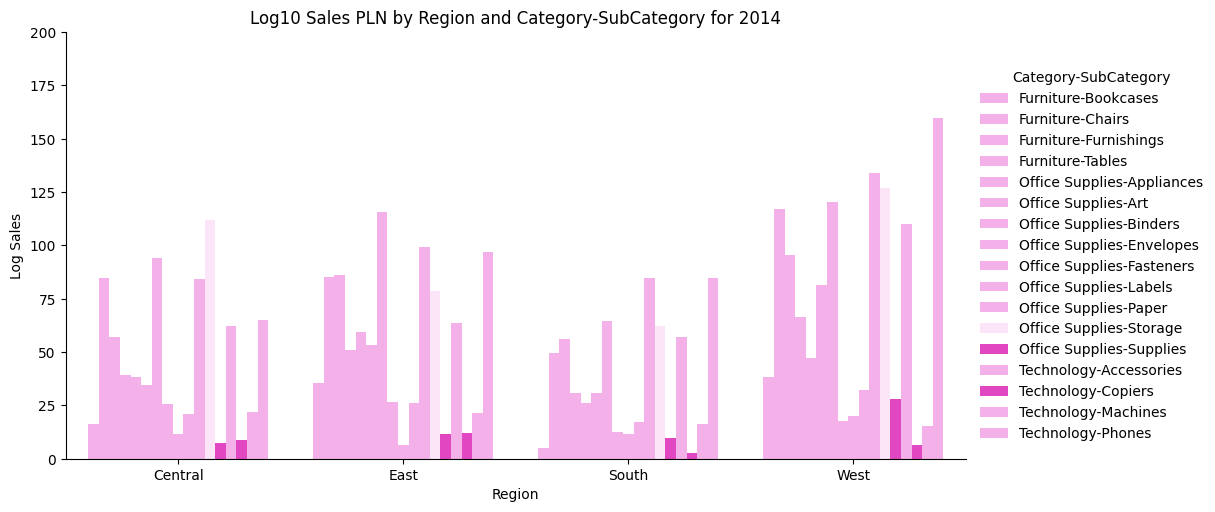

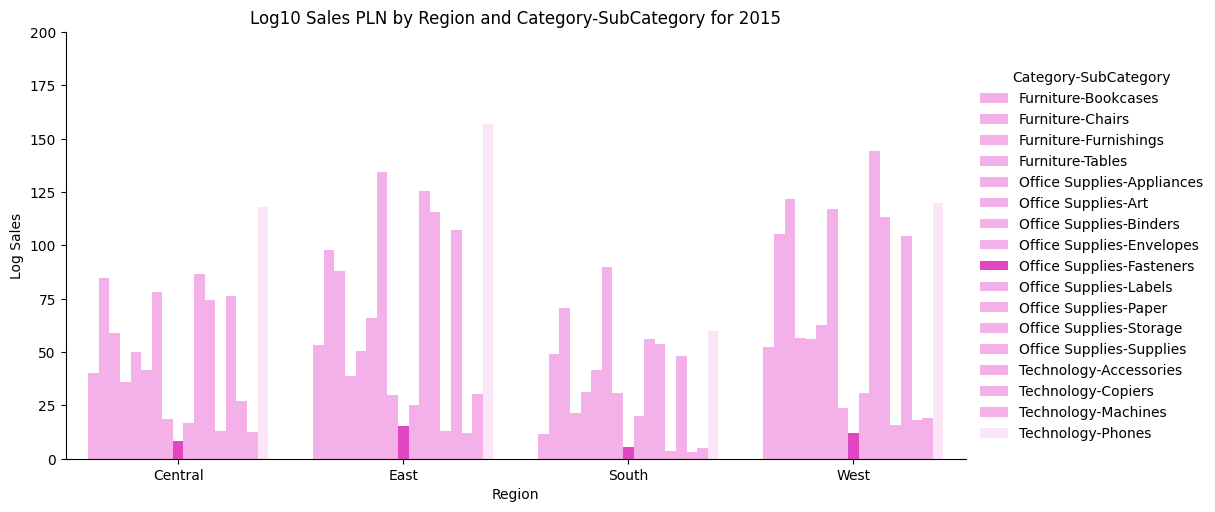

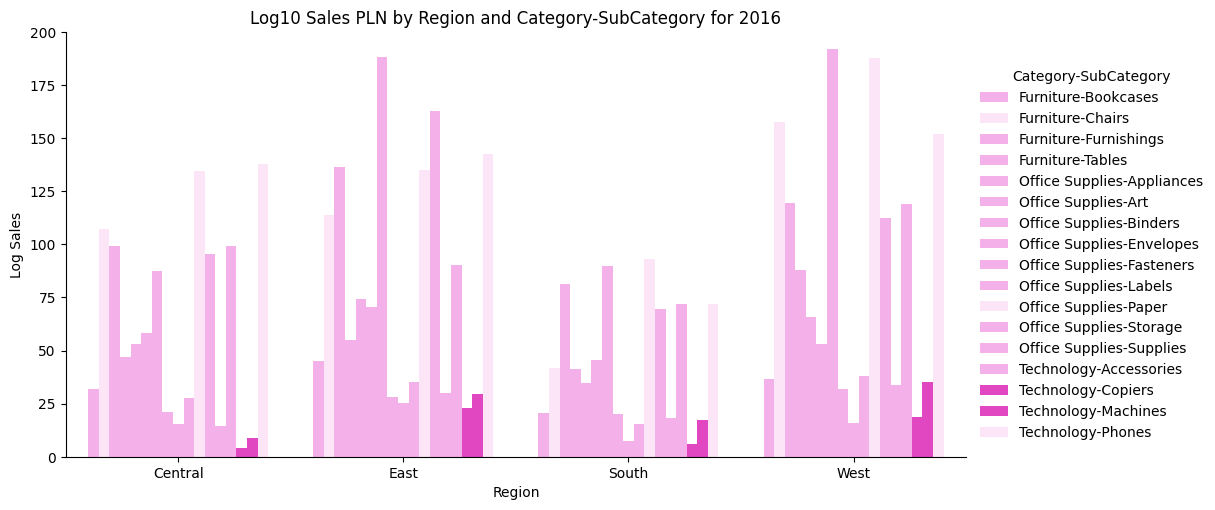

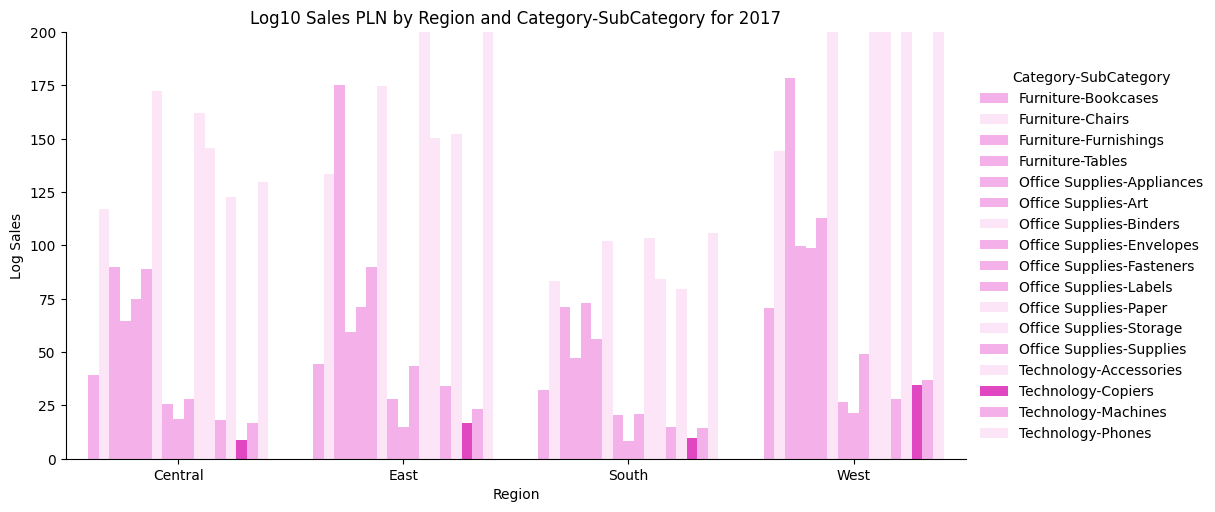

In [373]:
import seaborn as sns

# Define the function to generate a custom color palette
def color_palette(data, variable):
    colors = []
    for value in data[variable]:
        if value < 10:
            colors.append('#FA2DD0') # Light red
        elif value < 100:
            colors.append('#FFA5F0') # Medium red
        else:
            colors.append('#FFE1FA') # Dark red
    return colors

# Loop through the years and create the bar charts
for year in sorted(df['Order Year'].unique()):
    data = df[df['Order Year'] == year]
    pivot_table = data.groupby(['Region', 'Category-SubCategory']).agg({'Log Sales': 'sum'}).reset_index()

    # Set the color of the bars based on the Sales column
    my_palette = sns.color_palette(color_palette(pivot_table, 'Log Sales'))

    # Plot Sales by Region and SubCategory
    g = sns.catplot(data=pivot_table, x='Region', y='Log Sales', hue='Category-SubCategory', hue_order=HUE_ORDER, kind='bar', height=5, aspect=2, palette=my_palette)
    g.set(ylim=(0, 200))
    plt.title(f'Log10 Sales PLN by Region and Category-SubCategory for {year}')
    plt.show()


# Yearly Sales

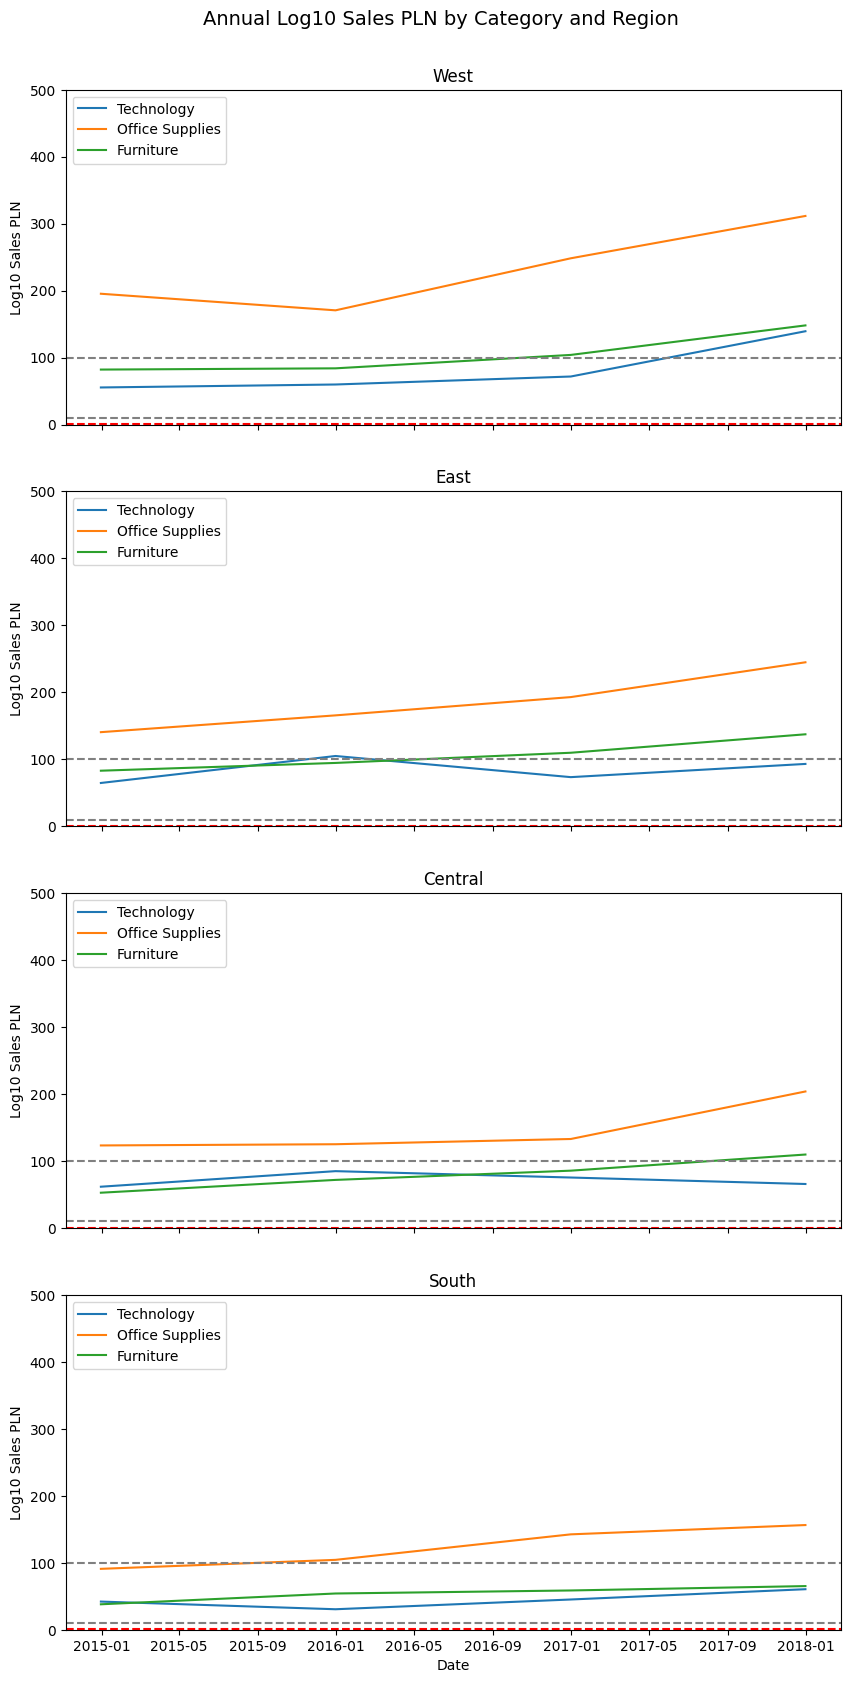

In [241]:
# Define the categories and regions
categories = df["Category"].unique()
regions = df["Region"].unique()

# Create subplots for each region
fig, axs = plt.subplots(len(regions), 1, figsize=(10, 20), sharex=True)

# Loop through each region
for i, region in enumerate(regions):
    # Select the data for the current region
    region_data = df_sample[df_sample["Region"] == region]
    # Loop through each category
    for j, category in enumerate(categories):
        # Select the data for the current category in the current region
        category_data = region_data[region_data["Category"] == category]
        # Resample the data to monthly intervals and calculate the sum
        monthly_data = category_data.resample('A').sum()
        # Plot the monthly sales line chart
        axs[i].plot(monthly_data.index, monthly_data['Log Sales'], label=category)
    # Set the title and y-axis label for the subplot
    axs[i].set_title(f"{region}")
    axs[i].set_ylabel("Log10 Sales PLN")
    axs[i].set(ylim=(0, 500))
    # Add horizontal lines at y=0.5 and y=10
    axs[i].axhline(y=0.5, color='r', linestyle='--')
    axs[i].axhline(y=10, color='gray', linestyle='--')
    axs[i].axhline(y=100, color='gray', linestyle='--')
    # Add the legend for the subplot
    axs[i].legend(loc="upper left")
# Set the x-axis label and title for the whole figure
plt.xlabel("Date")
fig.suptitle("Annual Log10 Sales PLN by Category and Region", fontsize=14, y=0.92)
# Show the plot
plt.show()


# Quarterly Sales

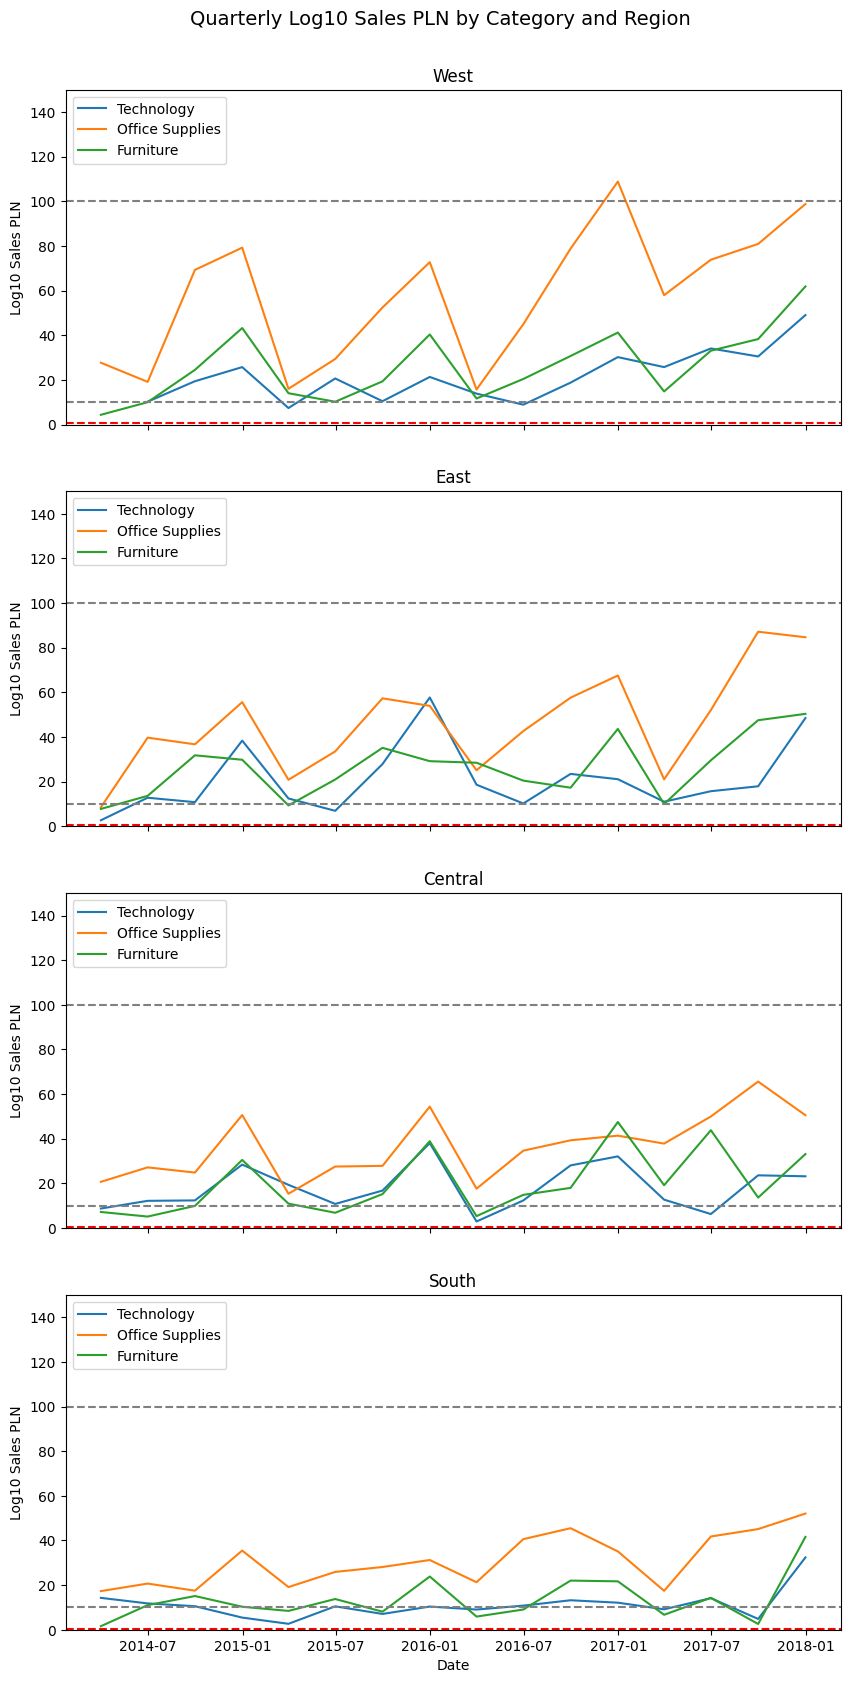

In [242]:
# Define the categories and regions
categories = df["Category"].unique()
regions = df["Region"].unique()

# Create subplots for each region
fig, axs = plt.subplots(len(regions), 1, figsize=(10, 20), sharex=True)

# Loop through each region
for i, region in enumerate(regions):
    # Select the data for the current region
    region_data = df_sample[df_sample["Region"] == region]
    # Loop through each category
    for j, category in enumerate(categories):
        # Select the data for the current category in the current region
        category_data = region_data[region_data["Category"] == category]
        # Resample the data to monthly intervals and calculate the sum
        monthly_data = category_data.resample('Q').sum()
        # Plot the monthly sales line chart
        axs[i].plot(monthly_data.index, monthly_data['Log Sales'], label=category)
    # Set the title and y-axis label for the subplot
    axs[i].set_title(f"{region}")
    axs[i].set_ylabel("Log10 Sales PLN")
    axs[i].set(ylim=(0, 150))
    # Add horizontal lines at y=0.5 and y=10
    axs[i].axhline(y=0.5, color='r', linestyle='--')
    axs[i].axhline(y=10, color='gray', linestyle='--')
    axs[i].axhline(y=100, color='gray', linestyle='--')
    # Add the legend for the subplot
    axs[i].legend(loc="upper left")
# Set the x-axis label and title for the whole figure
plt.xlabel("Date")
fig.suptitle("Quarterly Log10 Sales PLN by Category and Region", fontsize=14, y=0.92)
# Show the plot
plt.show()


# Monthly Sales

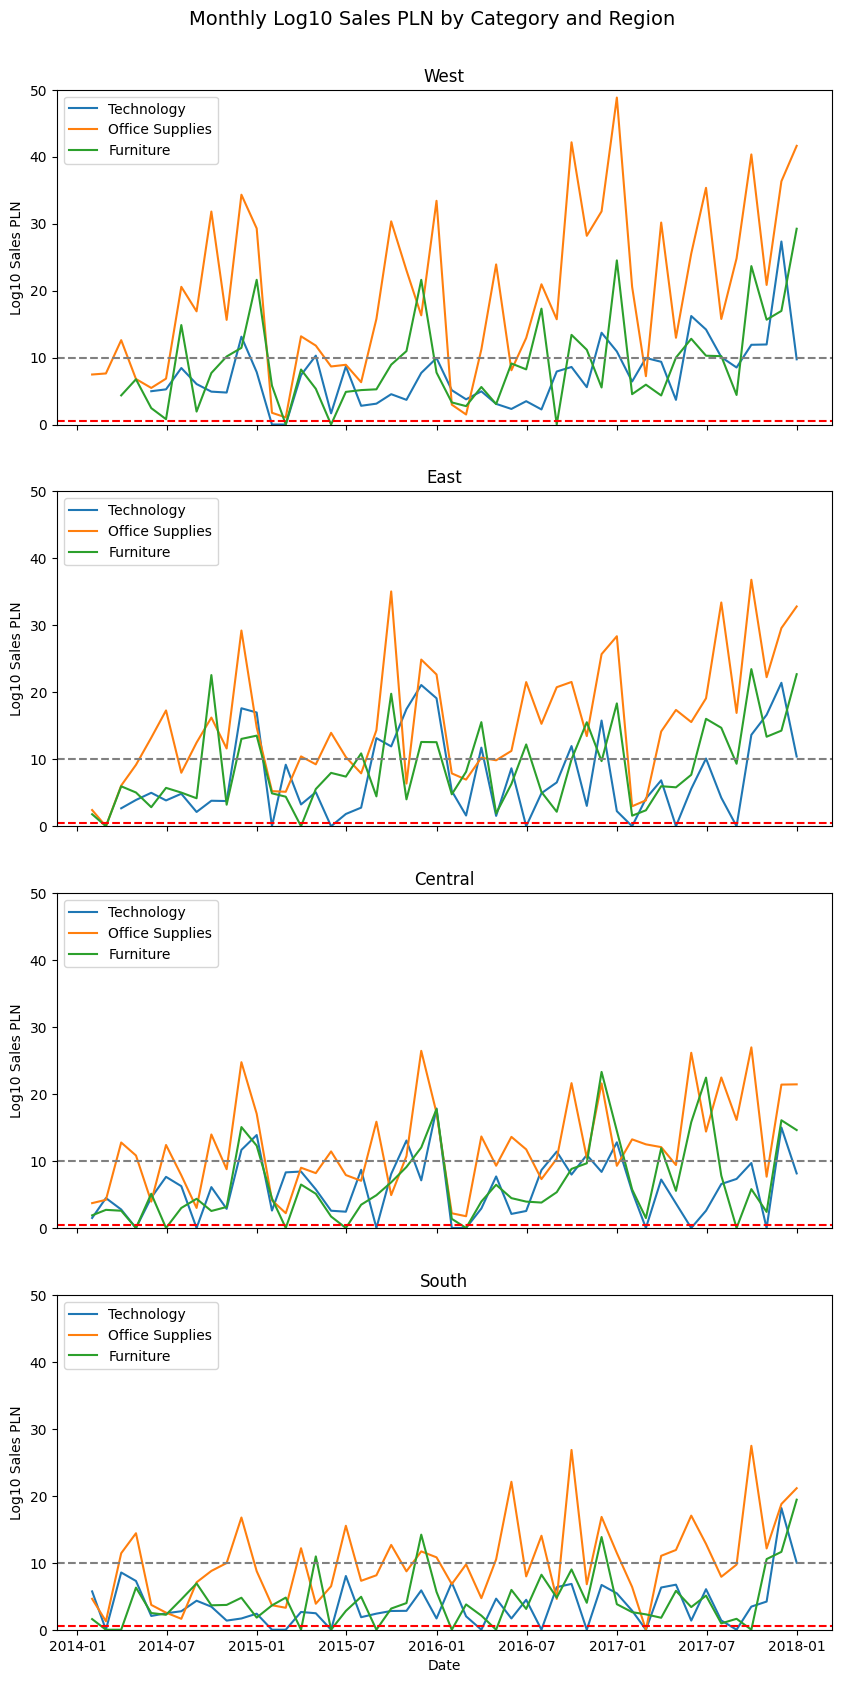

In [243]:
# Define the categories and regions
categories = df["Category"].unique()
regions = df["Region"].unique()

# Create subplots for each region
fig, axs = plt.subplots(len(regions), 1, figsize=(10, 20), sharex=True)

# Loop through each region
for i, region in enumerate(regions):
    # Select the data for the current region
    region_data = df_sample[df_sample["Region"] == region]
    # Loop through each category
    for j, category in enumerate(categories):
        # Select the data for the current category in the current region
        category_data = region_data[region_data["Category"] == category]
        # Resample the data to monthly intervals and calculate the sum
        monthly_data = category_data.resample('M').sum()
        # Plot the monthly sales line chart
        axs[i].plot(monthly_data.index, monthly_data['Log Sales'], label=category)
    # Set the title and y-axis label for the subplot
    axs[i].set_title(f"{region}")
    axs[i].set_ylabel("Log10 Sales PLN")
    axs[i].set(ylim=(0, 50))
    # Add horizontal lines at y=0.5 and y=10
    axs[i].axhline(y=0.5, color='r', linestyle='--')
    axs[i].axhline(y=10, color='gray', linestyle='--')
    # Add the legend for the subplot
    axs[i].legend(loc="upper left")
# Set the x-axis label and title for the whole figure
plt.xlabel("Date")
fig.suptitle("Monthly Log10 Sales PLN by Category and Region", fontsize=14, y=0.92)
# Show the plot
plt.show()


# SQL

In [63]:
conn = connect(':memory:')
df.to_sql('data', conn)

9993

# Furniture

In [325]:
agg_data = pd.read_sql(
"""
    SELECT
        "Order Year"
        ,"Order Month"
        ,Category
        ,SUM("Quantity") AS Quantity
        ,SUM("Sales") AS Sales
        ,SUM("Log Sales") AS LogSales
        ,SUM("Profit") AS Profit
    FROM data
    GROUP BY
        "Order Year"
        ,"Order Month"
        ,Category
    
""",
conn
)

In [326]:
# furniture_pivot = pd.pivot_table(furniture, values='Count', index=['Order Year', 'Category'],
#                           columns=['Order Month'], aggfunc=sum, fill_value=0)

In [327]:
# furniture_pivot

In [328]:
# # iterate over the multi-index
# for index, group in furniture_pivot.groupby(level=['Order Year', 'Category']):
# #     print('Order Year:', index[0])
#     print('Category:', index[1])
# #     print(group)

In [329]:
agg_data_pivot = pd.pivot_table(agg_data, values='Quantity', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

In [330]:
agg_data_pivot

Order Month   01   02   03   04   05   06   07   08    09    10    11    12
Order Year                                                                 
2014         284  159  585  536  466  521  550  609  1000   573  1219  1079
2015         236  239  515  543  575  486  557  598  1086   631  1306  1203
2016         358  306  579  635  863  742  758  693  1316   767  1406  1414
2017         597  363  885  733  887  931  840  884  1660  1133  1840  1723

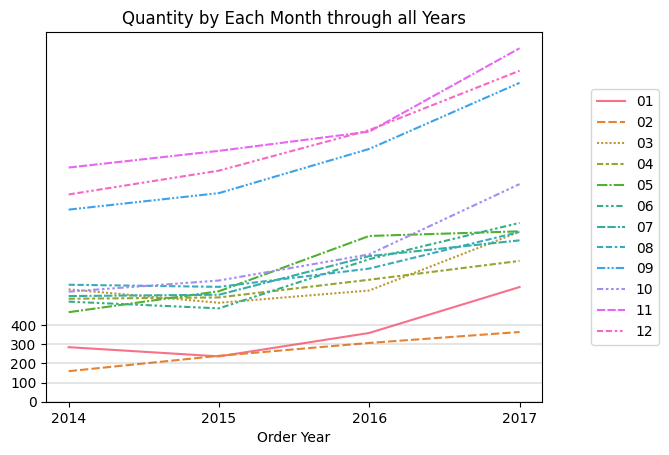

In [331]:
ax = sns.lineplot(data=agg_data_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Quantity by Each Month through all Years")
ax.set_yticks(list(range(0, 500, 100)))
for y in range(0, 500, 100):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

In [332]:
agg_data_pivot = pd.pivot_table(agg_data, values='Sales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

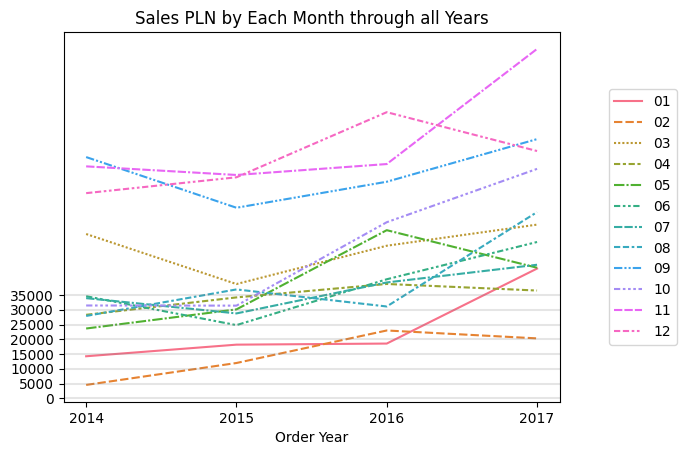

In [333]:
ax = sns.lineplot(data=agg_data_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Sales PLN by Each Month through all Years")
ax.set_yticks(list(range(0, 40000, 5000)))
for y in range(0, 40000, 5000):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

In [334]:
agg_data_pivot = pd.pivot_table(agg_data, values='LogSales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

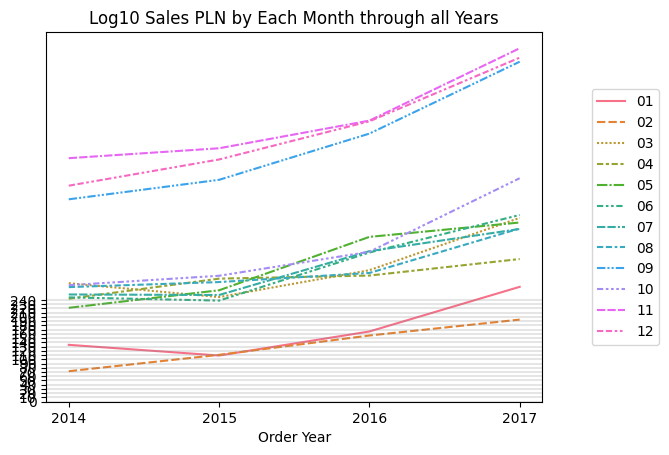

In [335]:
ax = sns.lineplot(data=agg_data_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Log10 Sales PLN by Each Month through all Years")
ax.set_yticks(list(range(0, 250, 10)))
for y in range(0, 250, 10):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

# Technology

In [336]:
technology = pd.read_sql(
"""
    SELECT
        "Order Year"
        ,"Order Month"
        ,Category
        ,SUM("Quantity") AS Quantity
        ,SUM("Sales") AS Sales
        ,SUM("Log Sales") AS LogSales
        ,SUM("Profit") AS Profit
    FROM data
    WHERE
        Category IN ('Technology')
    GROUP BY
        "Order Year"
        ,"Order Month"
        ,Category
    
""",
conn
)

In [337]:
technology_pivot = pd.pivot_table(technology, values='Quantity', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

In [338]:
technology_pivot

Order Month   01  02   03   04   05   06   07   08   09   10   11   12
Order Year                                                            
2014          45  33   84  110   88   77  103  126  168  111  250  194
2015          38  45   90  138   87   78  102  116  196  136  197  262
2016          72  53  130   81  161  124  126  135  198  115  269  234
2017         116  70  205   90  159  189  198  144  312  229  383  268

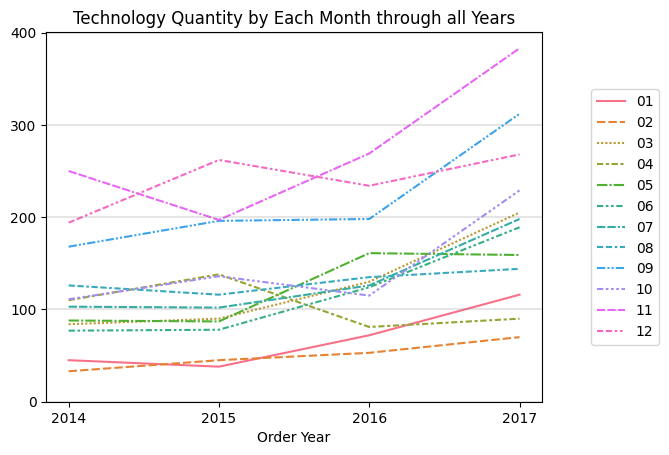

In [339]:
ax = sns.lineplot(data=technology_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Technology Quantity by Each Month through all Years")
ax.set_yticks(list(range(0, 500, 100)))
for y in range(0, 500, 100):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

In [340]:
technology_pivot = pd.pivot_table(technology, values='Sales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

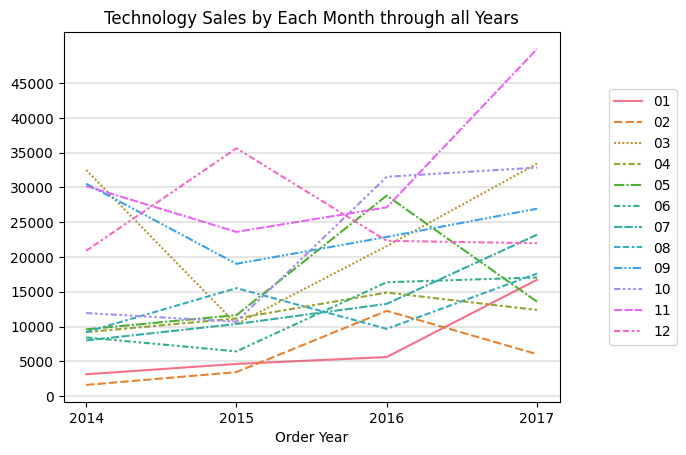

In [341]:
ax = sns.lineplot(data=technology_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Technology Sales by Each Month through all Years")
ax.set_yticks(list(range(0, 50000, 5000)))
for y in range(0, 50000, 5000):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

In [342]:
technology_pivot = pd.pivot_table(technology, values='LogSales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

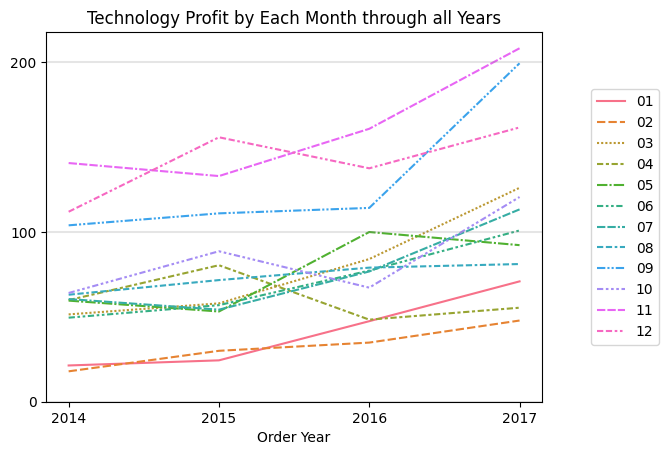

In [343]:
ax = sns.lineplot(data=technology_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Technology Profit by Each Month through all Years")
ax.set_yticks(list(range(0, 250, 100)))
for y in range(0, 250, 100):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

# Office supplies

In [354]:
office_supplies = pd.read_sql(
"""
    SELECT
        "Order Year"
        ,"Order Month"
        ,Category
        ,SUM("Quantity") AS Quantity
        ,SUM("Sales") AS Sales
        ,SUM("Log Sales") AS LogSales
        ,SUM("Profit") AS Profit
    FROM data
    WHERE
        Category IN ('Office Supplies')
    GROUP BY
        "Order Year"
        ,"Order Month"
        ,Category
    
""",
conn
)

In [355]:
office_supplies_pivot = pd.pivot_table(office_supplies, values='Quantity', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

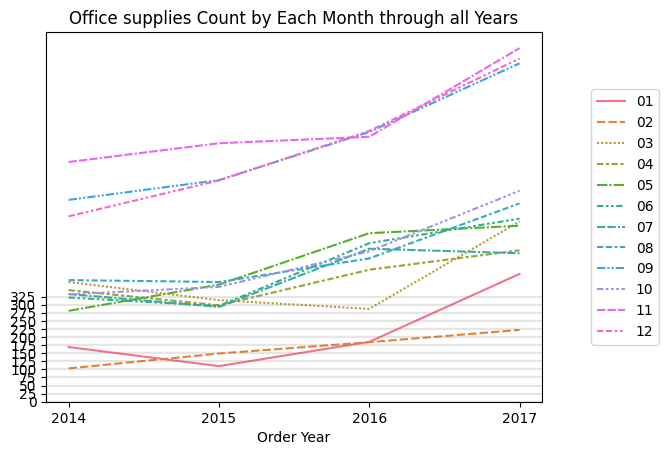

In [356]:
ax = sns.lineplot(data=office_supplies_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Office supplies Count by Each Month through all Years")
ax.set_yticks(list(range(0, 350, 25)))
for y in range(0, 350, 25):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

In [357]:
office_supplies_pivot = pd.pivot_table(office_supplies, values='Sales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

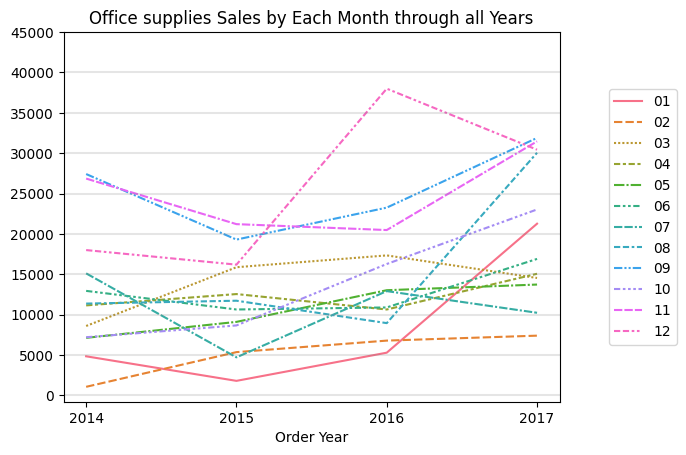

In [358]:
ax = sns.lineplot(data=office_supplies_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Office supplies Sales by Each Month through all Years")
ax.set_yticks(list(range(0, 50000, 5000)))
for y in range(0, 50000, 5000):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

In [359]:
office_supplies_pivot = pd.pivot_table(office_supplies, values='LogSales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

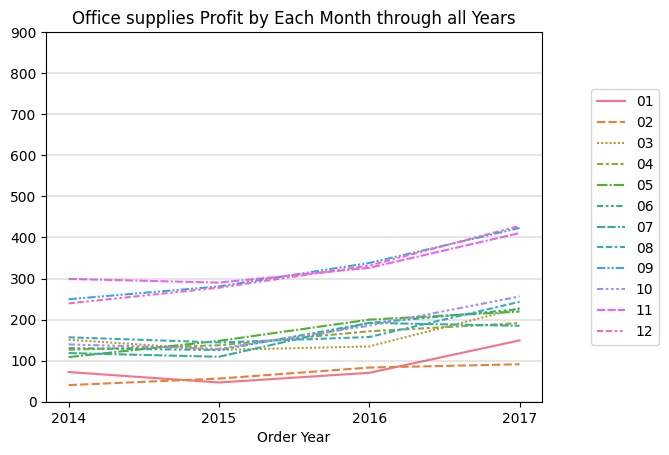

In [361]:
ax = sns.lineplot(data=office_supplies_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Office supplies Profit by Each Month through all Years")
ax.set_yticks(list(range(0, 1000, 100)))
for y in range(0, 1000, 100):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()